In [16]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor
import seaborn as sns

In [17]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:3]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c2pt_OTHER[i][j] /= N_factor
    for j in range(4):
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor

In [19]:
print(len(ts))

279552


## Prediction of c3pt at each time slice

In [4]:
## Features is a 64 x <# Data> x <Size Data> 3D array for all 64 sets of lists of features
## Labels is a 64 x <# Data> 2D array for all 64 sets of lists of labels

features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for i in range(64):
    features.append([])
    for f in features_unshifted:
        shift = int(f[0])
        features[i].append(np.roll(f[1:], -shift))

features = np.array(features)

labels_S_up = np.array([[c3pt_S[i+j][0] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_up = np.array([[c3pt_A[i+j][0] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_up = np.array([[c3pt_V[i+j][0] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

labels_S_down = np.array([[c3pt_S[i+j][2] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_down = np.array([[c3pt_A[i+j][2] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_down = np.array([[c3pt_V[i+j][2] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

In [15]:
## Shuffling data
perm = np.random.permutation(features.shape[1])
np.take(features, perm, axis=1, out=features)
np.take(labels_S_up, perm, axis=1, out=labels_S_up)
np.take(labels_A_up, perm, axis=1, out=labels_A_up)
np.take(labels_V_up, perm, axis=1, out=labels_V_up)
np.take(labels_S_down, perm, axis=1, out=labels_S_down)
np.take(labels_A_down, perm, axis=1, out=labels_A_down)
np.take(labels_V_down, perm, axis=1, out=labels_V_down)

array([[-2.90422063e-04, -4.26022050e-02, -3.48901849e-02, ...,
         3.14391108e-03,  1.94375303e+00,  3.13823221e-02],
       [ 4.35580689e-03, -4.59012737e-02, -4.07987094e-02, ...,
        -1.54605705e-02,  3.75349442e+00, -1.32349227e-02],
       [ 4.02137559e-03, -7.29890120e-02, -3.91944322e-02, ...,
         6.83585006e-03,  3.59720955e+00,  7.52929366e-03],
       ...,
       [ 4.82290149e-03, -6.67671798e-02, -4.23512386e-02, ...,
         3.70734444e-02,  1.42282424e-01,  9.37263686e-04],
       [ 1.14488841e-03, -5.55251734e-02, -3.12842273e-02, ...,
        -5.75891211e-02,  9.65586730e-02,  2.27670772e-02],
       [ 2.50113034e-03, -5.31510434e-02, -4.41562799e-02, ...,
         9.94398422e-02, -7.22595936e-02,  1.22020646e-02]])

## Scalar charge

In [4]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_S_up[0]) * labelFrac)
BCEnd    = int(len(labels_S_up[0]) * (BCFrac + labelFrac))

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_S_up[:, :labelEnd], labels_S_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[:, labelEnd:BCEnd], labels_S_up[:, labelEnd:BCEnd], labels_S_down[:, labelEnd:BCEnd]
X_test, Y_test_up, Y_test_down = features[:, BCEnd:], labels_S_up[:, BCEnd:], labels_S_down[:, BCEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
biasCrxn_up = list(range(64))
biasCrxn_down = list(range(64))
for i in range(64):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

    y_bc_pred_up = gbr_up[i].predict(X_bc[i])
    y_bc_pred_down = gbr_down[i].predict(X_bc[i])

    biasCrxn_up[i] = np.average(Y_bc_up - y_bc_pred_up)
    biasCrxn_down[i] = np.average(Y_bc_down - y_bc_pred_down)

Prediction quality @ t=0: 0.2160242116841916


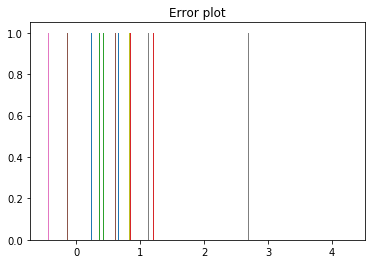

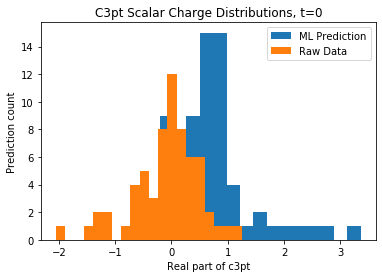

Prediction quality @ t=1: 0.2587080524643809


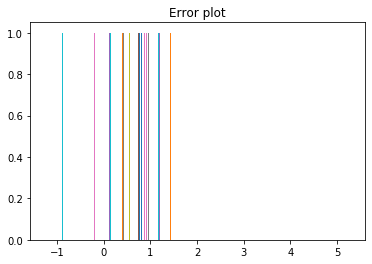

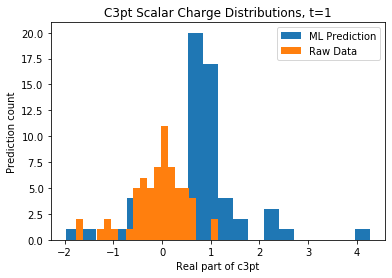

Prediction quality @ t=2: 0.3245633548773169


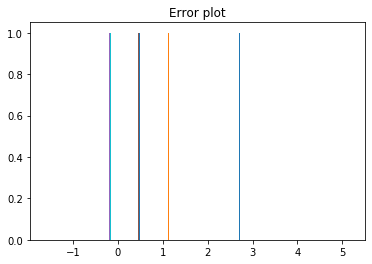

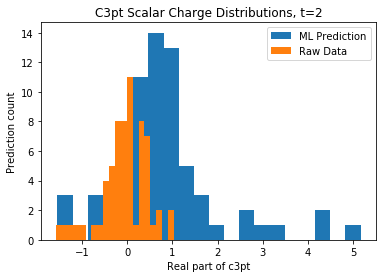

Prediction quality @ t=3: 0.41073970164360074


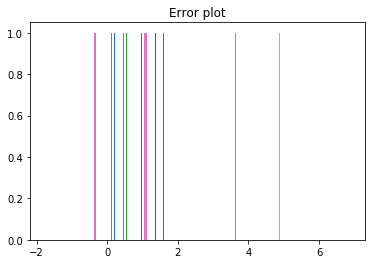

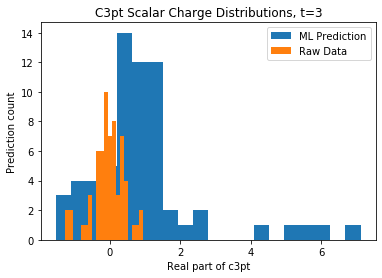

Prediction quality @ t=4: 0.39380666768525885


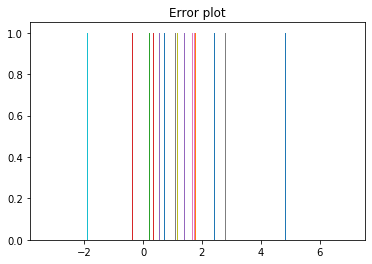

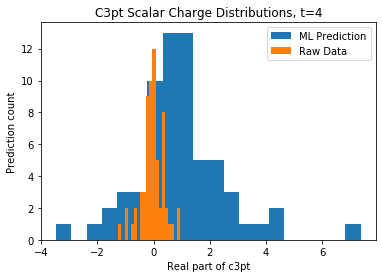

Prediction quality @ t=5: 0.47489236386253225


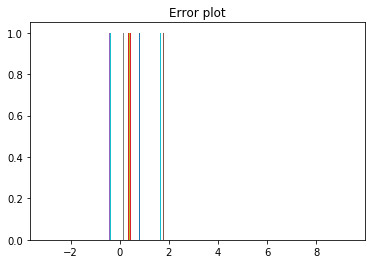

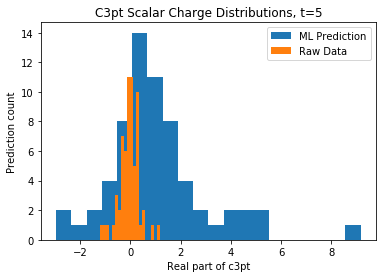

Prediction quality @ t=6: 0.5025865321929458


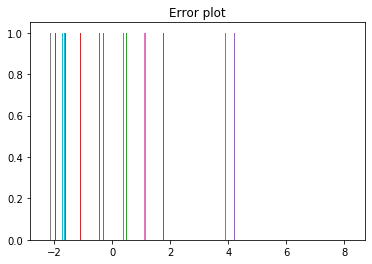

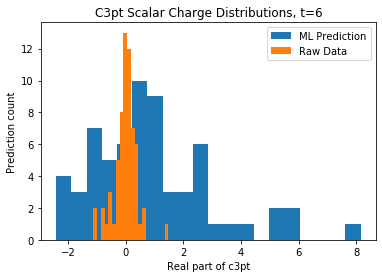

Prediction quality @ t=7: 0.5953170448418167


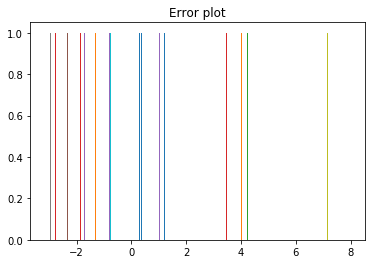

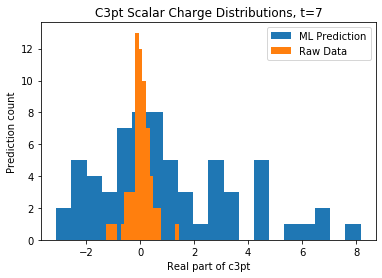

Prediction quality @ t=8: 0.6949387072126475


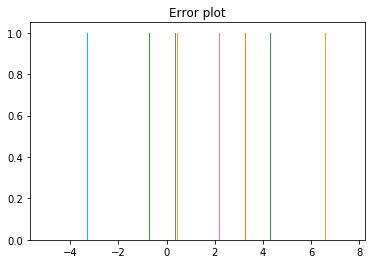

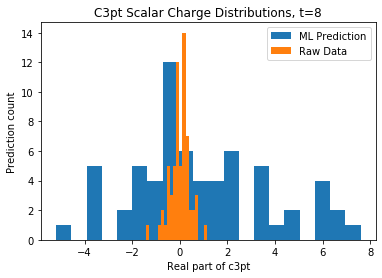

Prediction quality @ t=9: 20.433133148184016


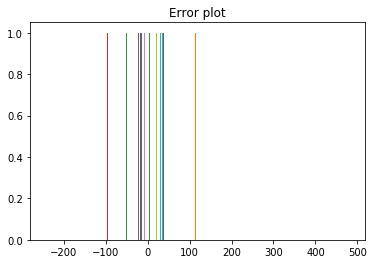

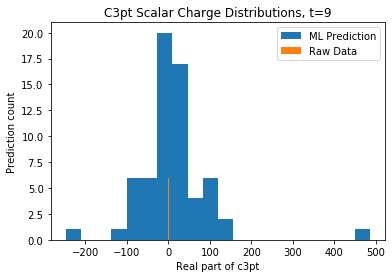

Prediction quality @ t=10: 1.14256728233156


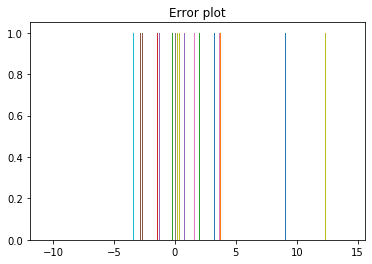

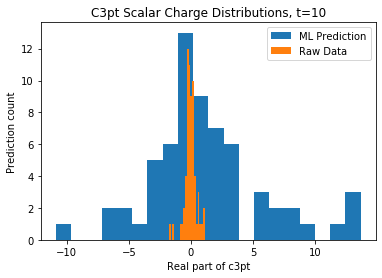

Prediction quality @ t=11: 1.1804223644021203


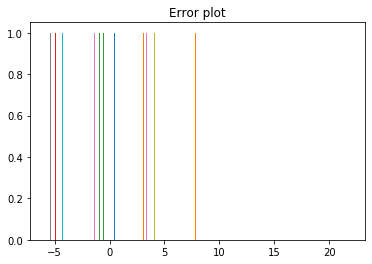

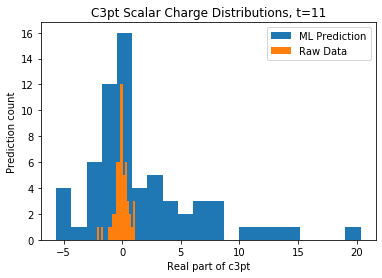

Prediction quality @ t=12: 1.2089784114314783


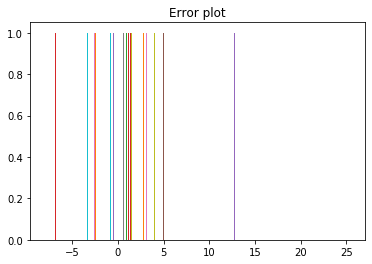

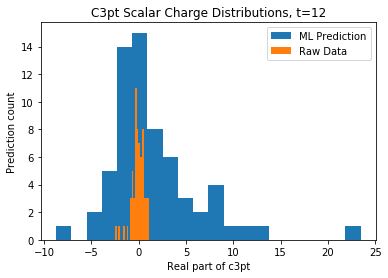

Prediction quality @ t=13: 1.1081760100680287


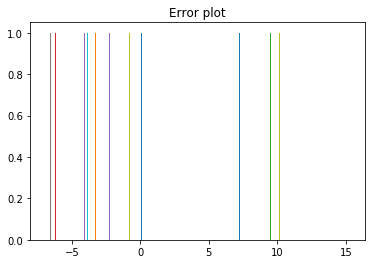

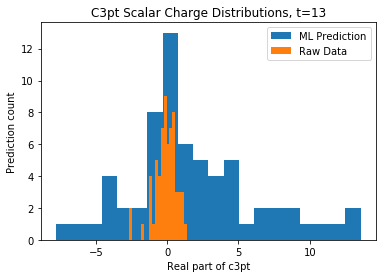

Prediction quality @ t=14: 1.188340180417969


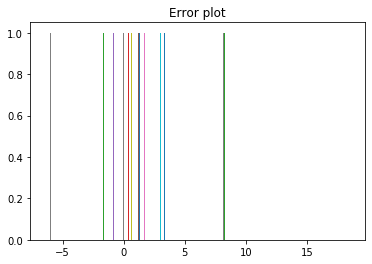

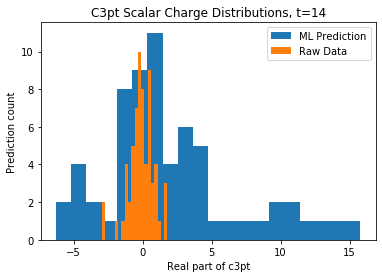

Prediction quality @ t=15: 1.3332937470403248


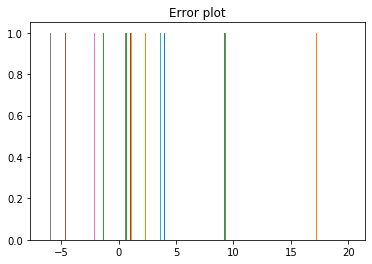

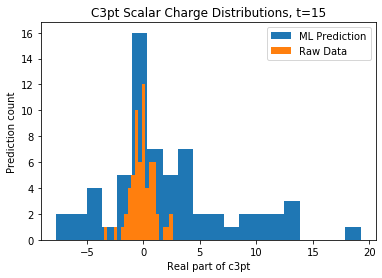

Prediction quality @ t=16: 1.415950441082177


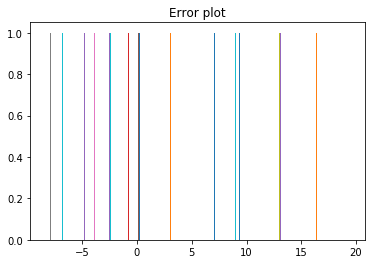

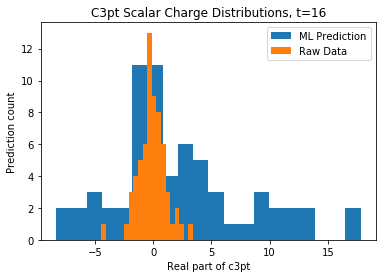

Prediction quality @ t=17: 56.402402318328974


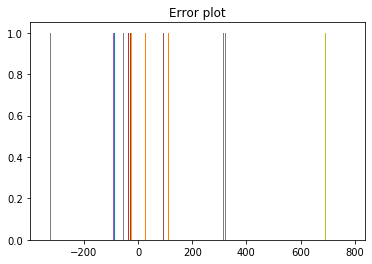

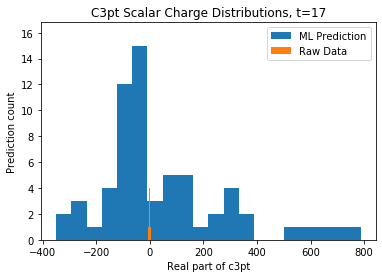

Prediction quality @ t=18: 1.2870944141330198


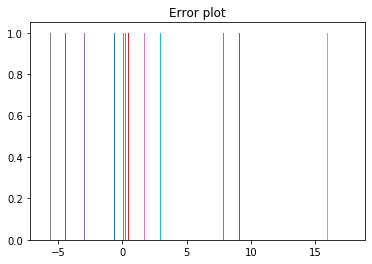

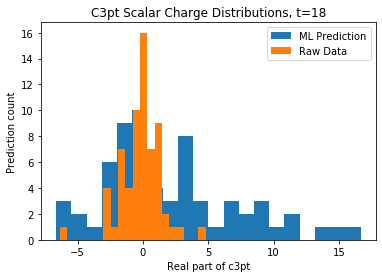

Prediction quality @ t=19: 1.2317385964176515


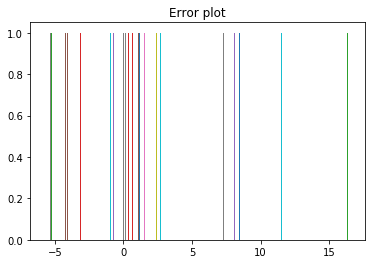

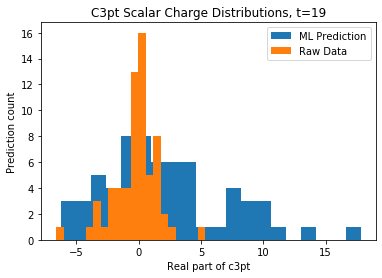

Prediction quality @ t=20: 1.135074480510889


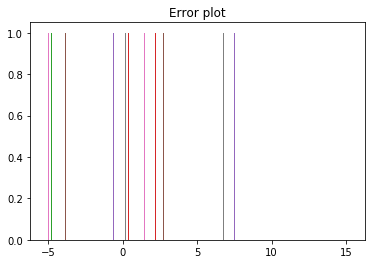

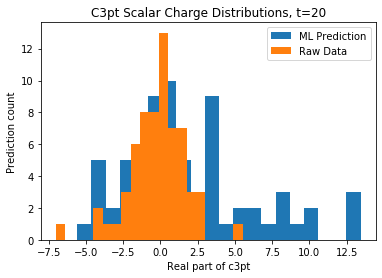

Prediction quality @ t=21: 1.133086291987987


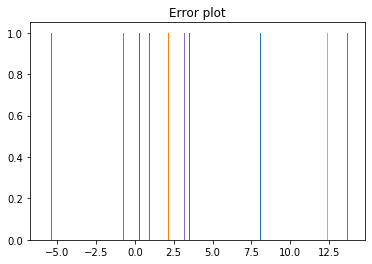

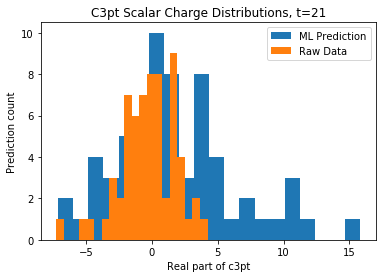

Prediction quality @ t=22: 1.1656530662760132


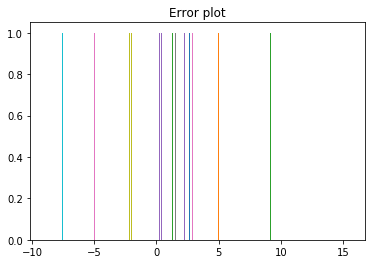

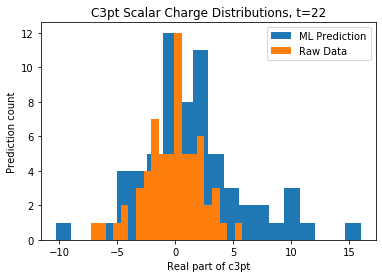

Prediction quality @ t=23: 1.2189479561963823


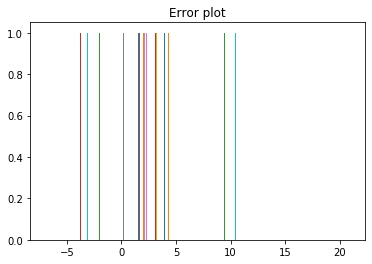

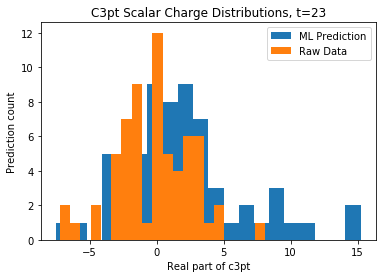

Prediction quality @ t=24: 1.1364869402549815


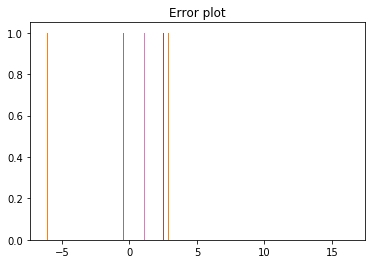

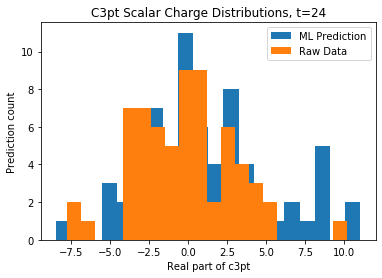

Prediction quality @ t=25: 63.49780010387811


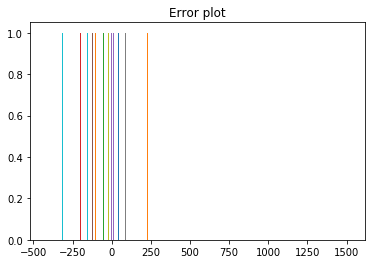

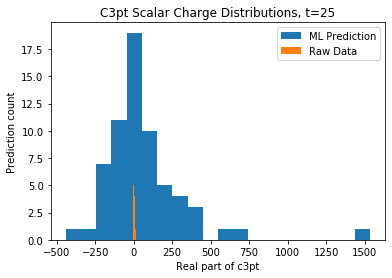

Prediction quality @ t=26: 1.193205708739484


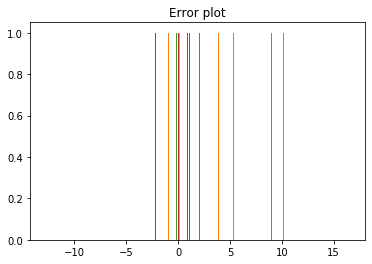

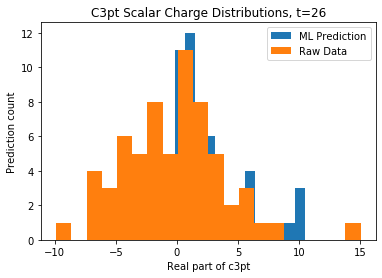

Prediction quality @ t=27: 1.3056317988671886


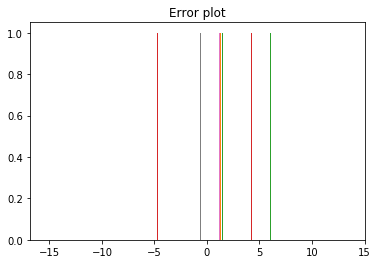

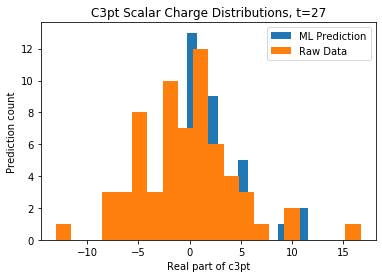

Prediction quality @ t=28: 1.3039190968210683


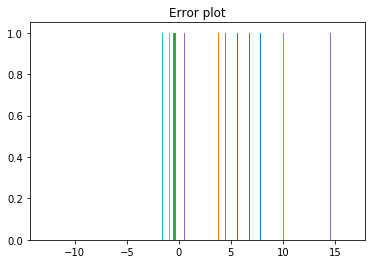

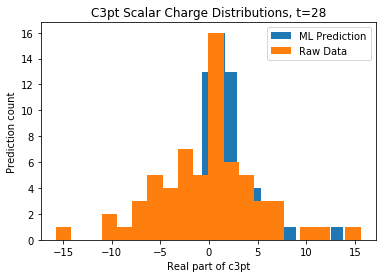

Prediction quality @ t=29: 1.3563600123903043


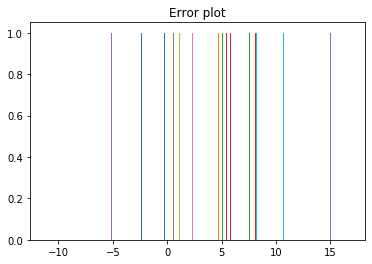

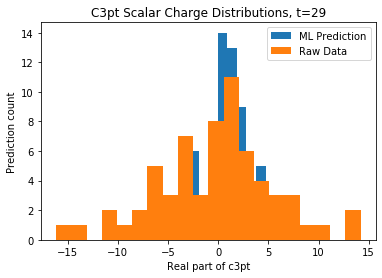

Prediction quality @ t=30: 1.5077075072504136


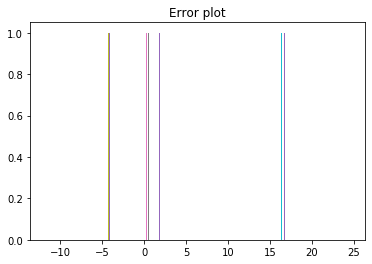

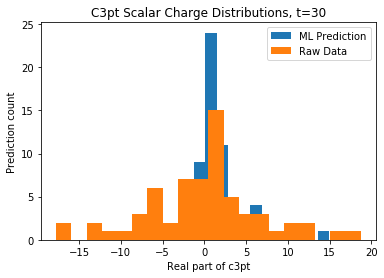

Prediction quality @ t=31: 1.6394675823557783


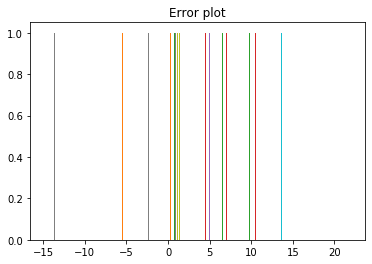

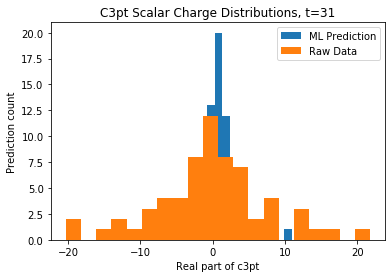

Prediction quality @ t=32: 1.7304581434101614


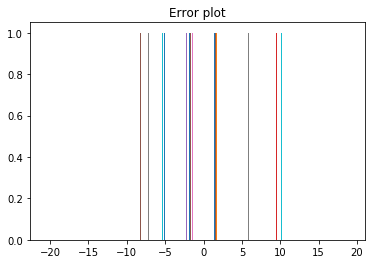

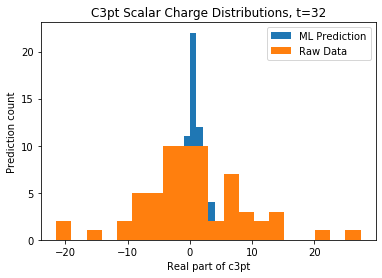

Prediction quality @ t=33: 31.224024473622023


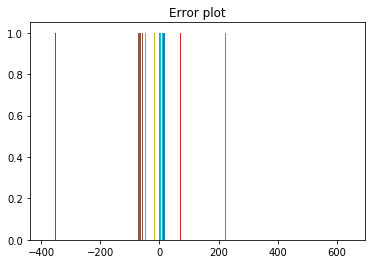

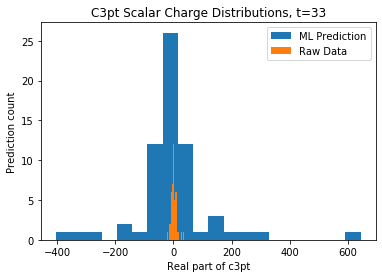

Prediction quality @ t=34: 2.0665596556871293


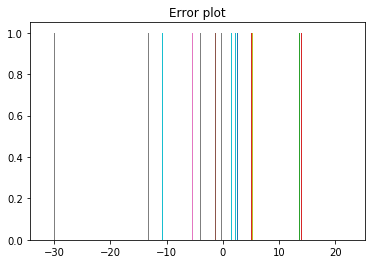

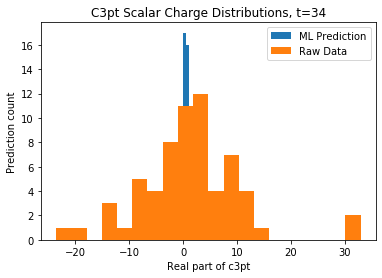

Prediction quality @ t=35: 2.1298507911505484


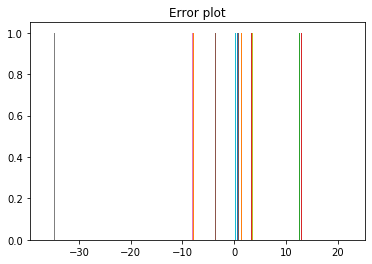

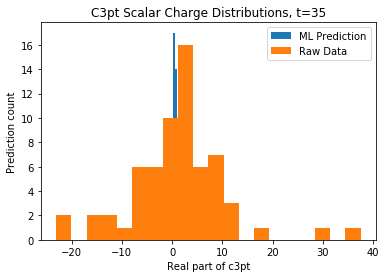

Prediction quality @ t=36: 2.189784599300226


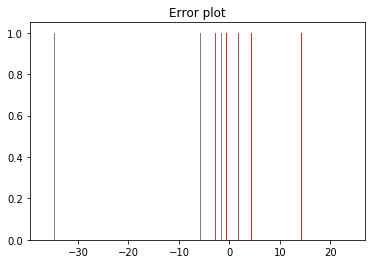

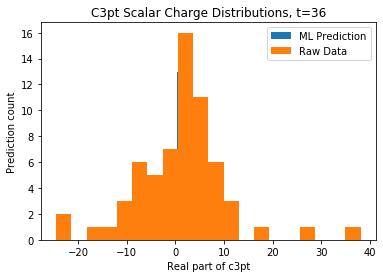

Prediction quality @ t=37: 2.166579856062445


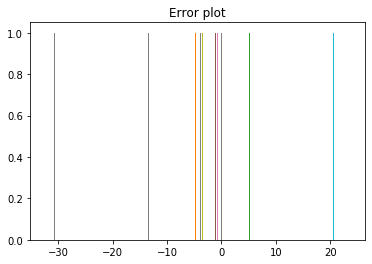

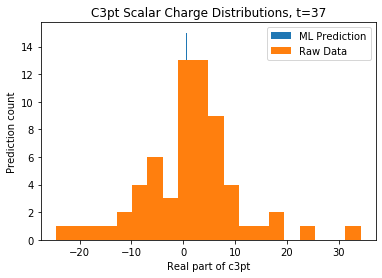

Prediction quality @ t=38: 2.1742927864813337


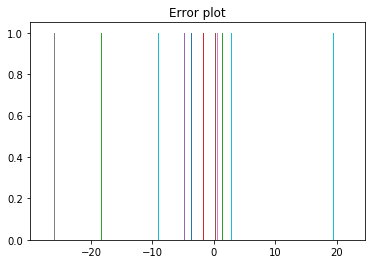

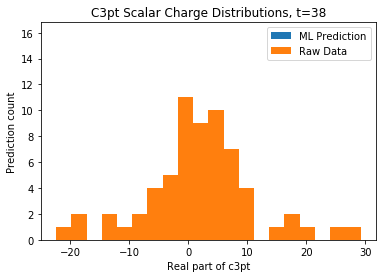

Prediction quality @ t=39: 2.2067763459358702


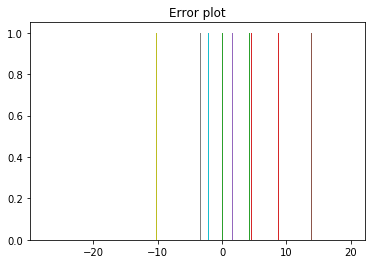

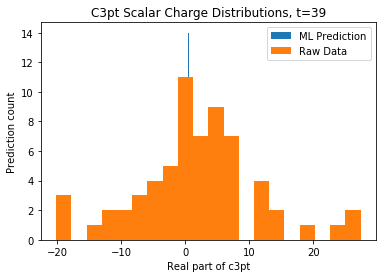

Prediction quality @ t=40: 2.181236077213837


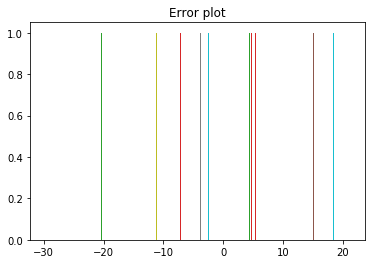

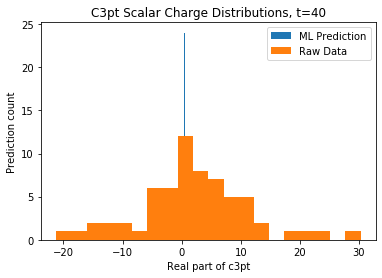

Prediction quality @ t=41: 186.8914054375906


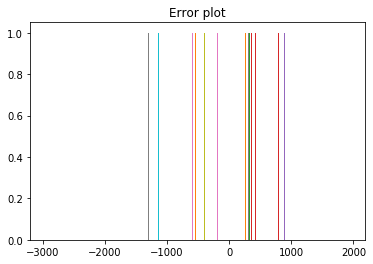

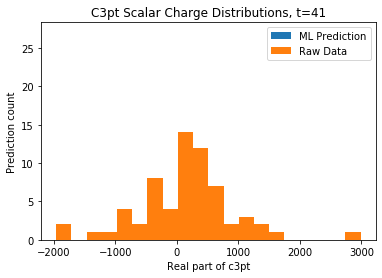

Prediction quality @ t=42: 1.8974517836015337


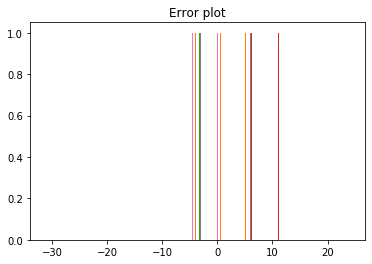

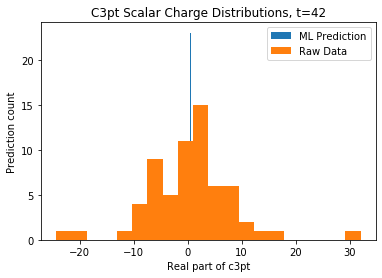

Prediction quality @ t=43: 1.5941795224528452


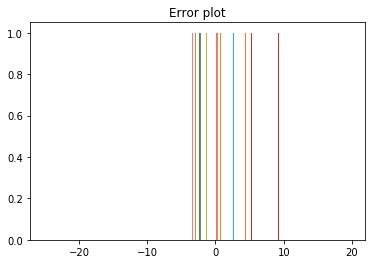

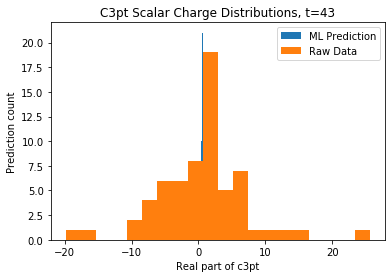

Prediction quality @ t=44: 1.3211388165408884


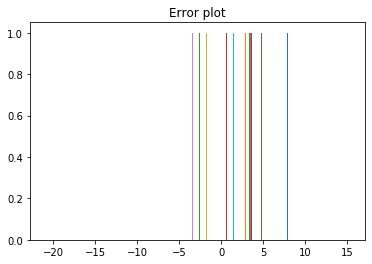

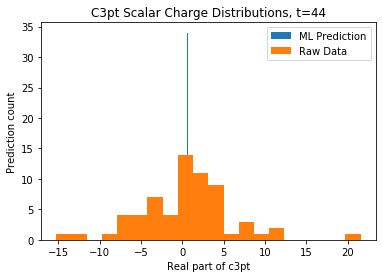

Prediction quality @ t=45: 1.0565117880516122


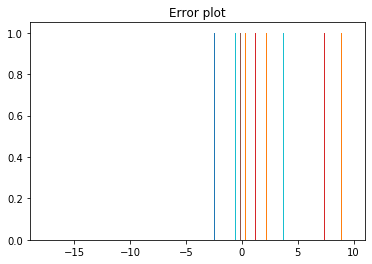

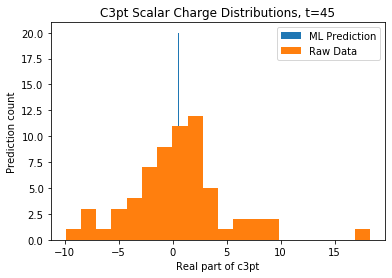

Prediction quality @ t=46: 0.8244642540866821


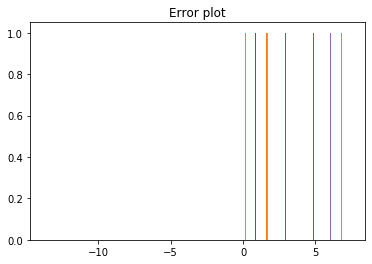

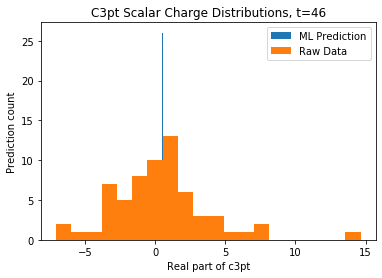

Prediction quality @ t=47: 0.6586125229252163


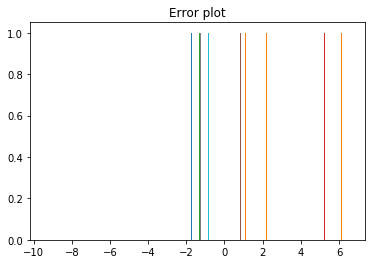

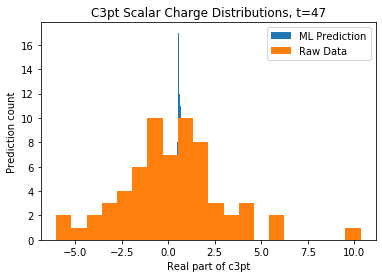

Prediction quality @ t=48: 0.5467880353051363


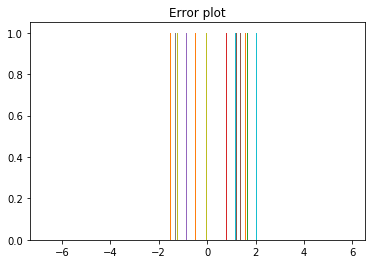

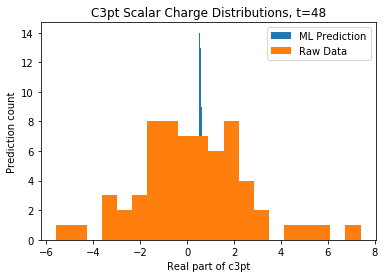

Prediction quality @ t=49: 0.5015685024988686


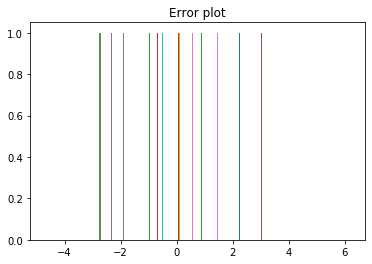

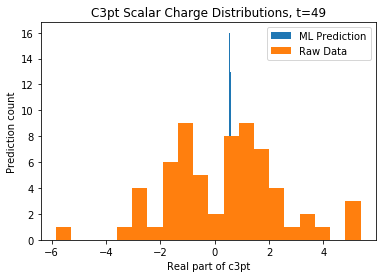

Prediction quality @ t=50: 0.488272203726035


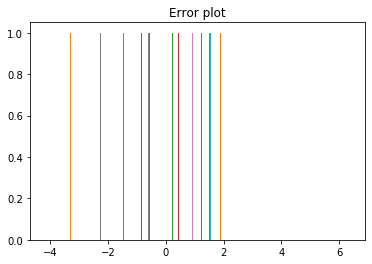

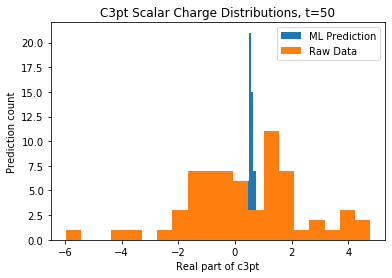

Prediction quality @ t=51: 0.4703932957800362


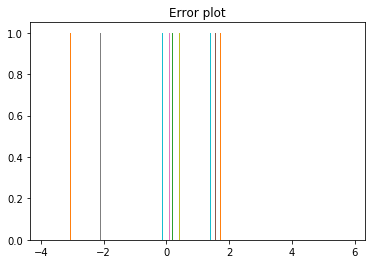

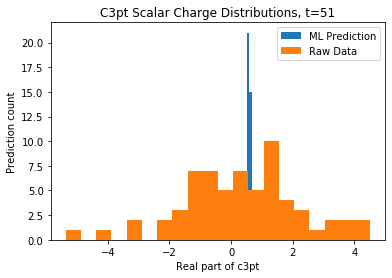

Prediction quality @ t=52: 0.4438548914729504


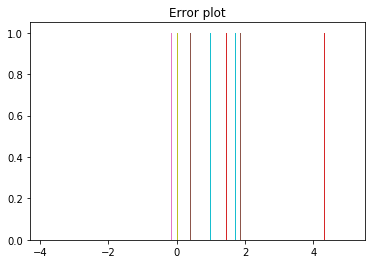

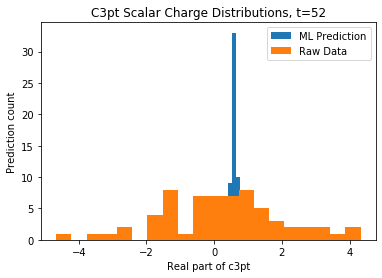

Prediction quality @ t=53: 0.3700895077152173


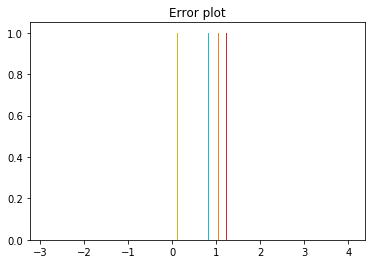

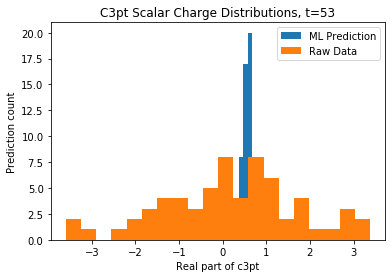

Prediction quality @ t=54: 0.31845619260121044


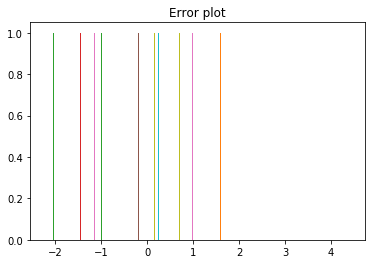

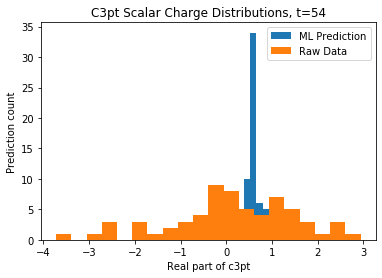

Prediction quality @ t=55: 0.292649315561663


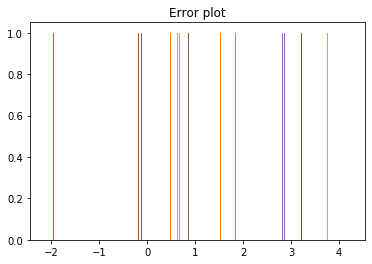

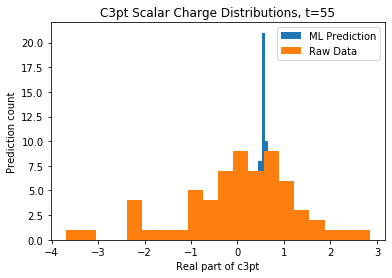

Prediction quality @ t=56: 0.2819842264605322


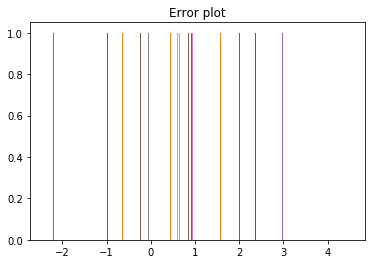

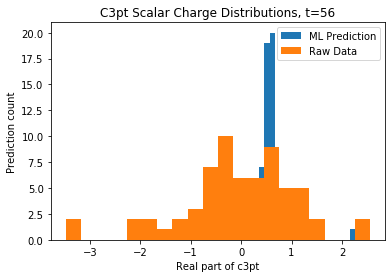

Prediction quality @ t=57: 0.2697711832252063


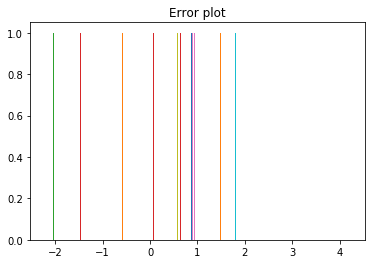

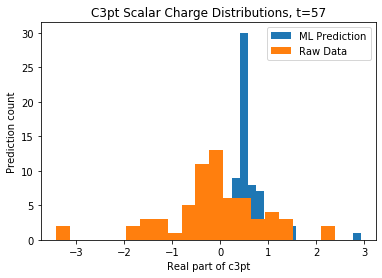

Prediction quality @ t=58: 0.26097735486539037


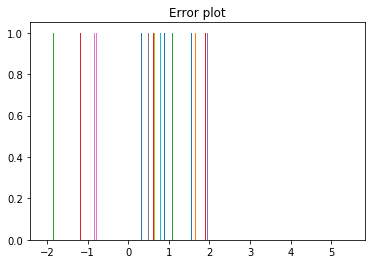

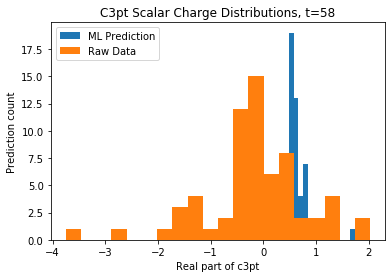

Prediction quality @ t=59: 0.23730726059788554


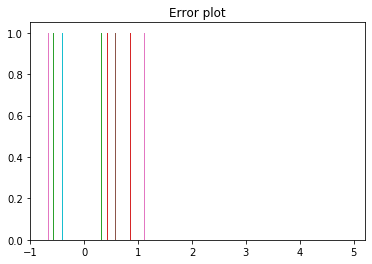

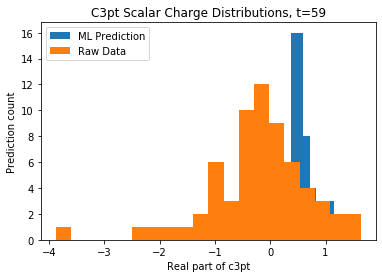

Prediction quality @ t=60: 0.2192133734637296


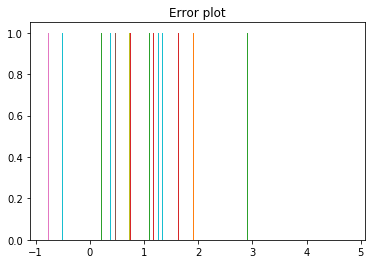

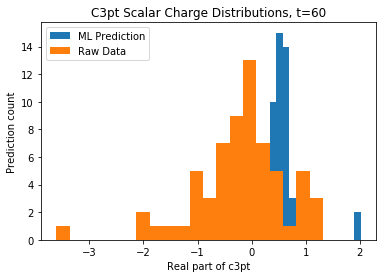

Prediction quality @ t=61: 0.21484348677655105


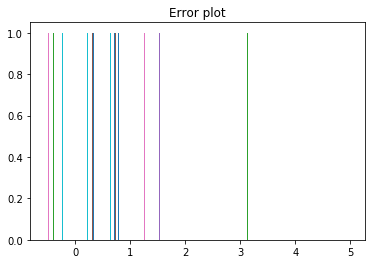

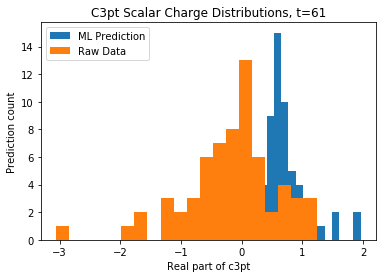

Prediction quality @ t=62: 0.21722844486001563


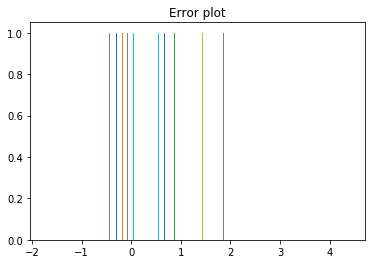

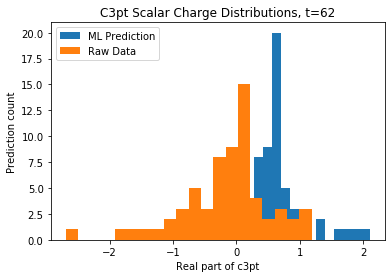

Prediction quality @ t=63: 0.24148300677274


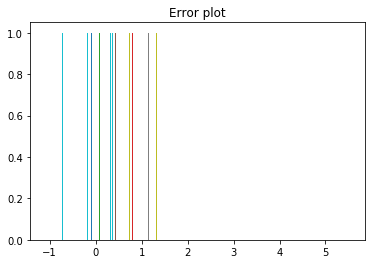

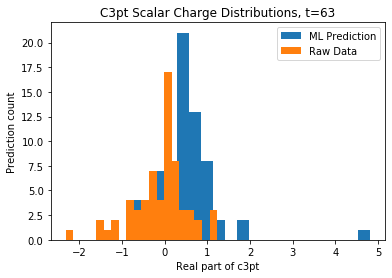

NameError: name 'Y_train' is not defined

In [7]:
for t in range(64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(X_train[t]))
    
    plt.hist(errors, bins=20)
    plt.title("Error plot")
    plt.show()

    plt.hist(ML_samples, bins=20)
    plt.hist(DM_samples, bins=20)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

## Vector Charge Prediction

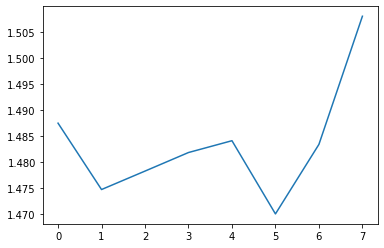

In [35]:
labelFrac = 0.3
BCFrac = 0.4

samps = 8

labelEnd = int(len(labels_S_up[0]) * labelFrac)
BCEnd    = int(len(labels_S_up[0]) * (BCFrac + labelFrac))

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[:, labelEnd:BCEnd], labels_V_up[:, labelEnd:BCEnd], labels_V_down[:, labelEnd:BCEnd]
X_test, Y_test_up, Y_test_down = features[:, BCEnd:], labels_V_up[:, BCEnd:], labels_V_down[:, BCEnd:]

gbr_up = list(range(samps))
gbr_down = list(range(samps))
biasCrxn_up = list(range(samps))
biasCrxn_down = list(range(samps))
for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

    y_bc_pred_up = gbr_up[i].predict(X_bc[i])
    y_bc_pred_down = gbr_down[i].predict(X_bc[i])

    biasCrxn_up[i] = np.average(Y_bc_up - y_bc_pred_up)
    biasCrxn_down[i] = np.average(Y_bc_down - y_bc_pred_down)

Prediction quality @ t=0: 0.05360040706992417


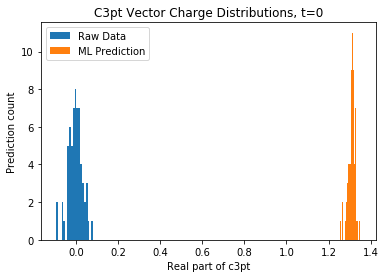

Prediction quality @ t=1: 0.04072957165056459


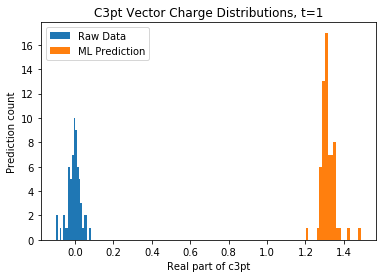

Prediction quality @ t=2: 0.043280492995710566


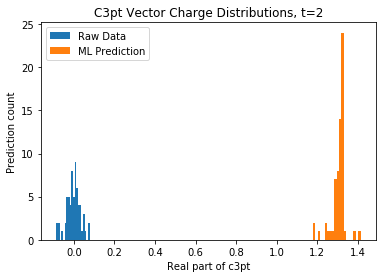

Prediction quality @ t=3: 0.05109210904699729


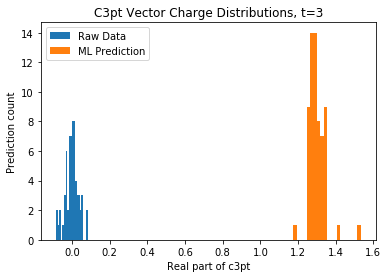

Prediction quality @ t=4: 0.032190335637608126


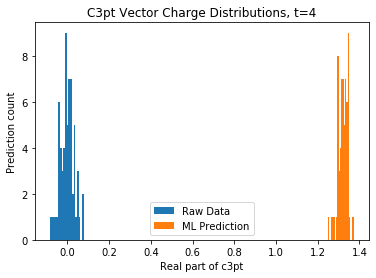

Prediction quality @ t=5: 0.03479344782862186


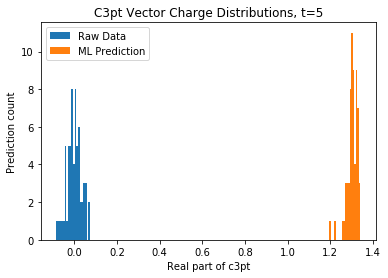

Prediction quality @ t=6: 0.0314209625768118


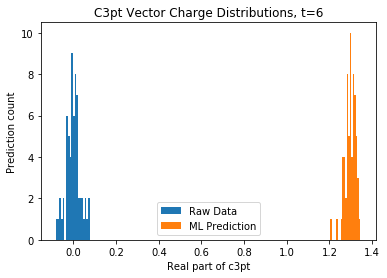

Prediction quality @ t=7: 0.054271069704233045


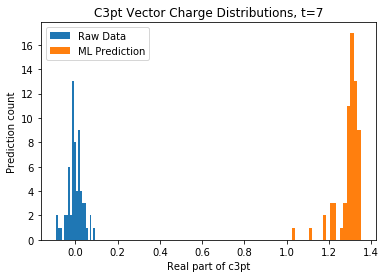

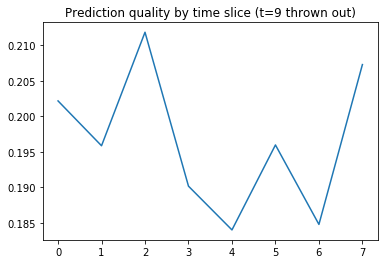

In [28]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))

    plt.hist(DM_samples, bins=20)
    plt.hist(ML_samples, bins=20)
    plt.legend(["Raw Data", "ML Prediction"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(Y_train_up[t]))
    
for i in range(9, samps, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(samps)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

## Vector Charge Prediction With ML Bias Correction

In [38]:
labelFrac = 0.5

labelEnd = int(len(labels_V_up[0]) * labelFrac)

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_test, Y_test_up, Y_test_down = features[:, labelEnd:], labels_V_up[:, labelEnd:], labels_V_down[:, labelEnd:]

samps = 64

gbr_up = list(range(samps))
gbr_down = list(range(samps))
gbr_up_congl = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr_down_congl = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)

for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

# Y_train_up_avg = np.sum(Y_train_up, axis=0) / len(Y_train_up)
# Y_train_down_avg = np.sum(Y_train_down, axis=0) / len(Y_train_down)

# gbr_up_congl.fit(X_train[0], Y_train_up_avg)
# gbr_down_congl.fit(X_train[0], Y_train_down_avg)

Prediction quality @ t=0: 0.2683412313007251


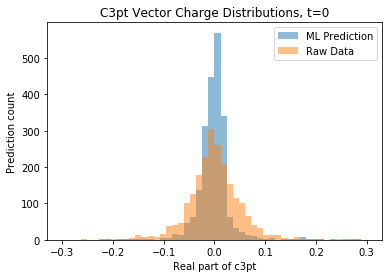

Prediction quality @ t=1: 0.2523528522529506


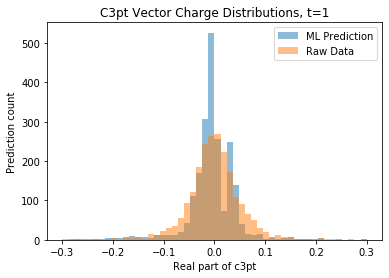

Prediction quality @ t=2: 0.2944282373516758


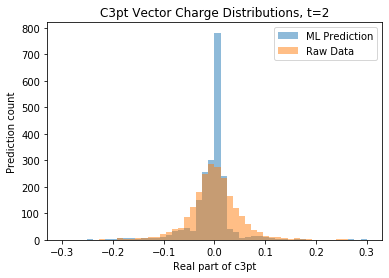

Prediction quality @ t=3: 0.21694484844580925


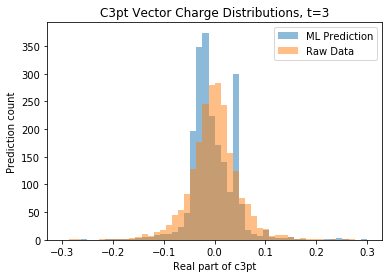

Prediction quality @ t=4: 0.2415937046898096


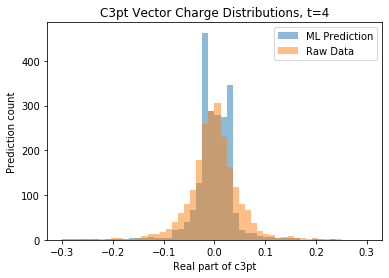

Prediction quality @ t=5: 0.26638933737046055


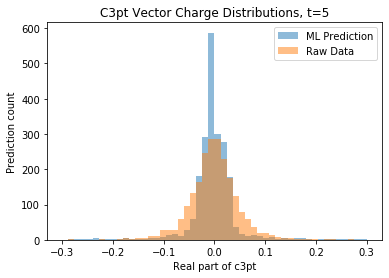

Prediction quality @ t=6: 0.24715368498063808


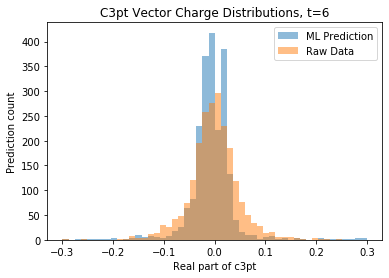

Prediction quality @ t=7: 0.2705337986236557


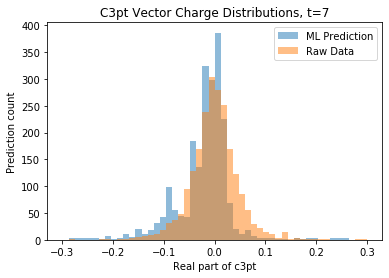

Prediction quality @ t=8: 0.39827315684724873


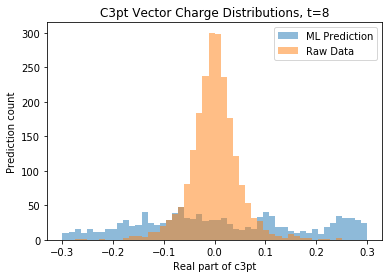

Prediction quality @ t=9: 0.4641729920157097


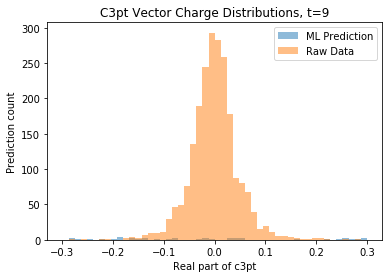

Prediction quality @ t=10: 0.6642282113731874


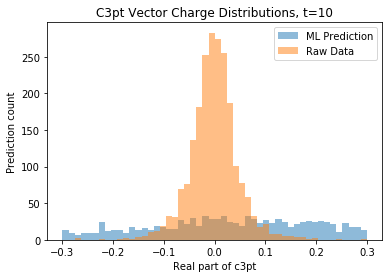

Prediction quality @ t=11: 0.6666835904149824


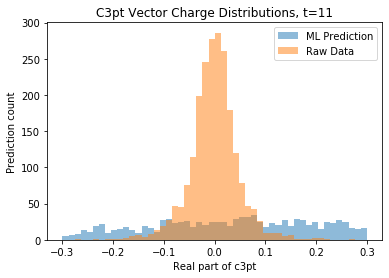

Prediction quality @ t=12: 0.6575101829464535


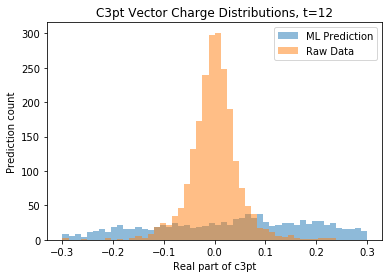

Prediction quality @ t=13: 0.6595207627544124


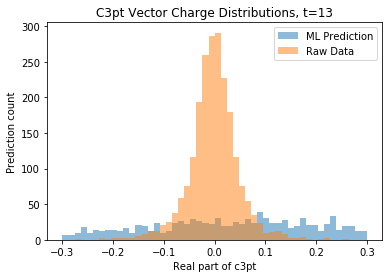

Prediction quality @ t=14: 0.6610864630623743


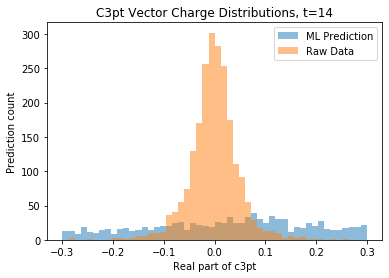

Prediction quality @ t=15: 0.6379852708196541


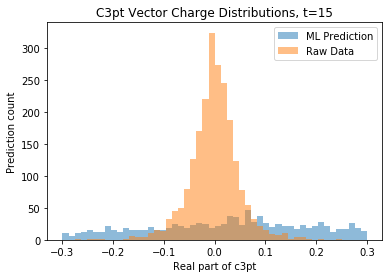

Prediction quality @ t=16: 0.8765337867598305


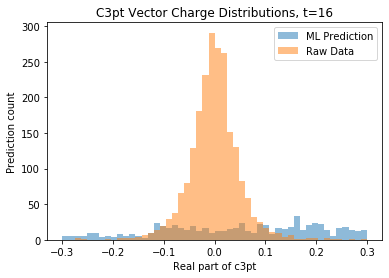

Prediction quality @ t=17: 0.5833093531755065


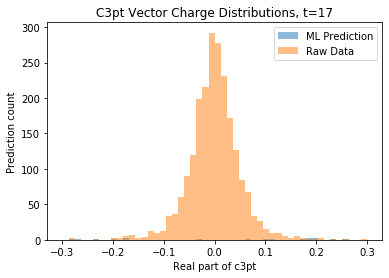

Prediction quality @ t=18: 0.6259382467925306


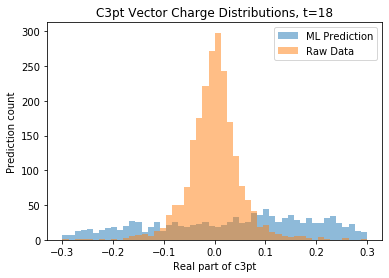

Prediction quality @ t=19: 0.6553304929059319


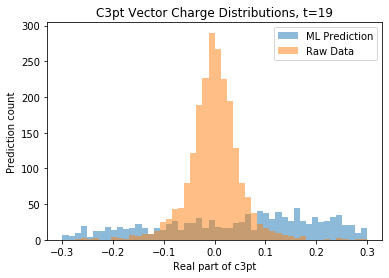

Prediction quality @ t=20: 0.6431474154196731


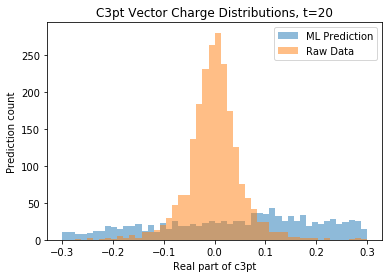

Prediction quality @ t=21: 0.6486717119469717


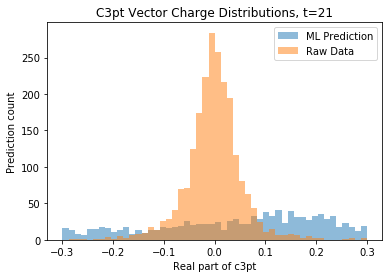

Prediction quality @ t=22: 0.6505366630493796


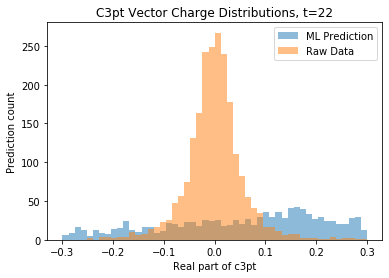

Prediction quality @ t=23: 0.642658547841957


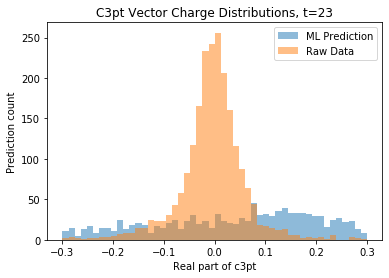

Prediction quality @ t=24: 0.771235007038127


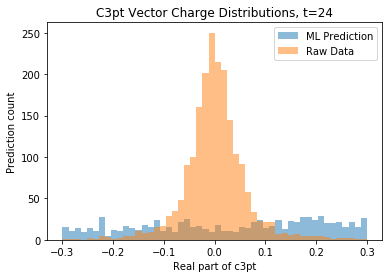

Prediction quality @ t=25: 0.6005938596696185


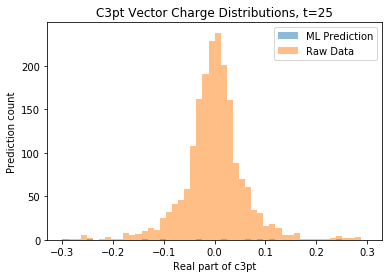

Prediction quality @ t=26: 1.2135197802745414


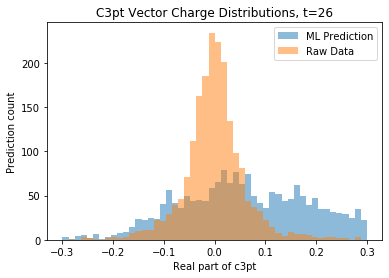

Prediction quality @ t=27: 1.2161371727549763


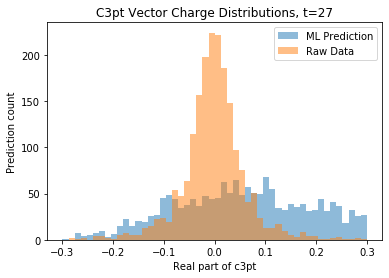

Prediction quality @ t=28: 1.2264505893952524


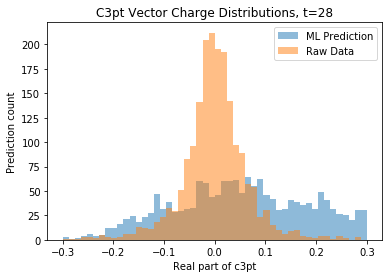

Prediction quality @ t=29: 1.2654278916747153


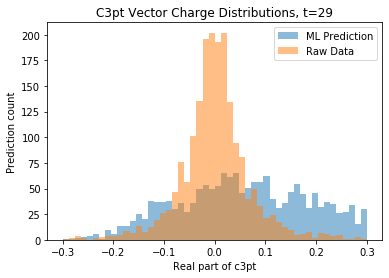

Prediction quality @ t=30: 1.2487976583775473


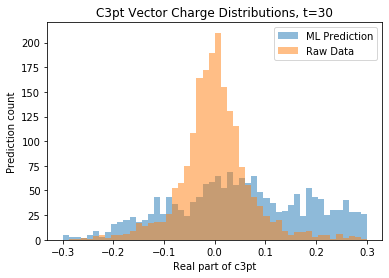

Prediction quality @ t=31: 1.2704785106502736


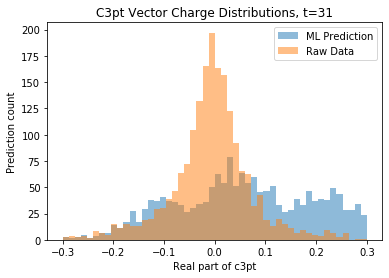

Prediction quality @ t=32: 1.2695048189847764


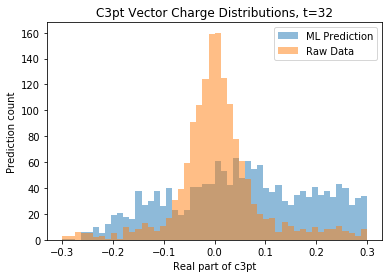

Prediction quality @ t=33: 1.2165006664901246


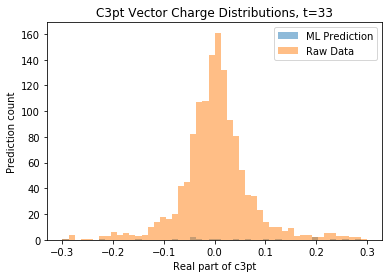

Prediction quality @ t=34: 17.429725675269925


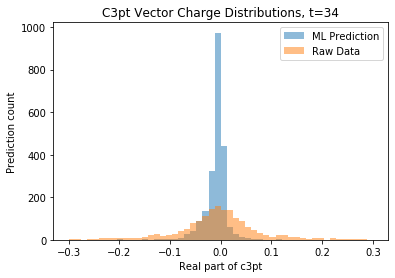

Prediction quality @ t=35: 21.3906608868643


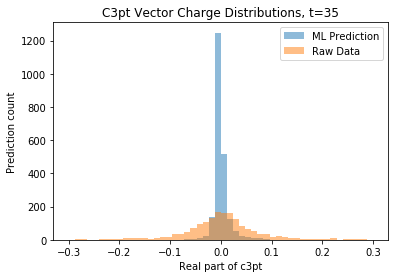

Prediction quality @ t=36: 21.299681104826384


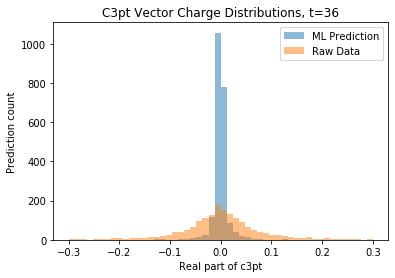

Prediction quality @ t=37: 22.42009728921604


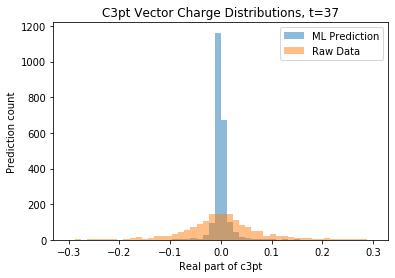

Prediction quality @ t=38: 23.135423765216313


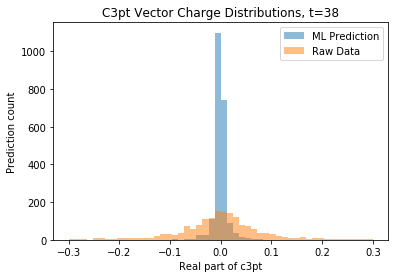

Prediction quality @ t=39: 23.45011213885676


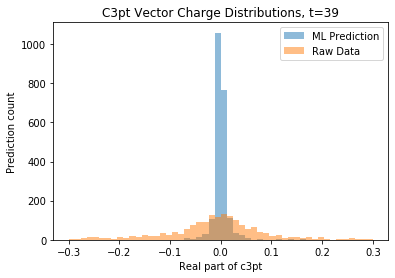

Prediction quality @ t=40: 27.274245648332112


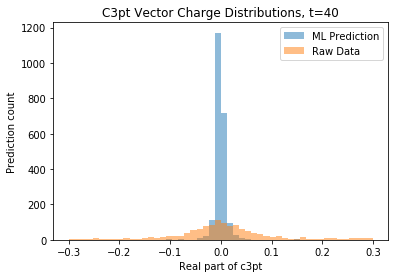

Prediction quality @ t=41: 2690.0633383012237


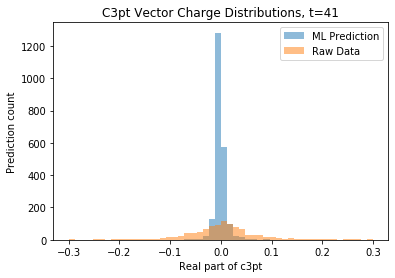

Prediction quality @ t=42: 23.800953755426367


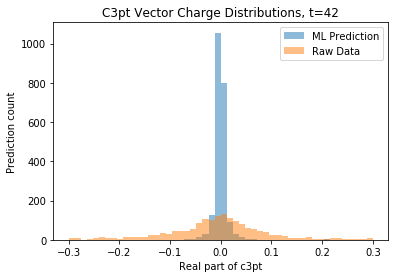

Prediction quality @ t=43: 23.853601508196192


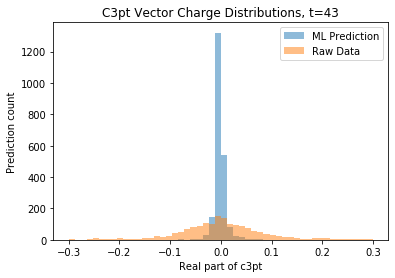

Prediction quality @ t=44: 23.25110447961615


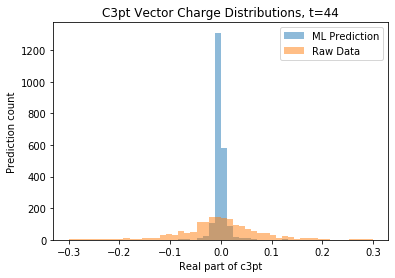

Prediction quality @ t=45: 24.36732881680437


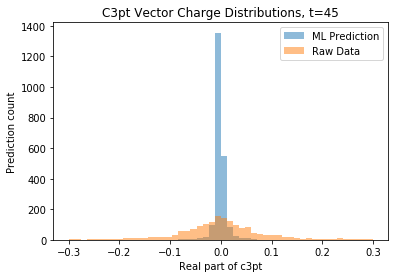

Prediction quality @ t=46: 24.312212615676433


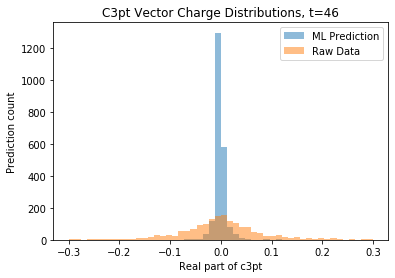

Prediction quality @ t=47: 24.223851098275198


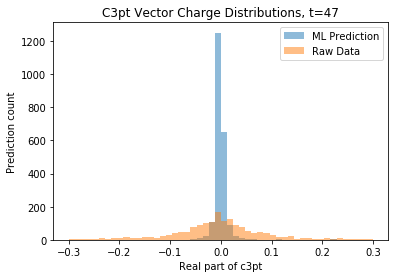

Prediction quality @ t=48: 27.619136436660067


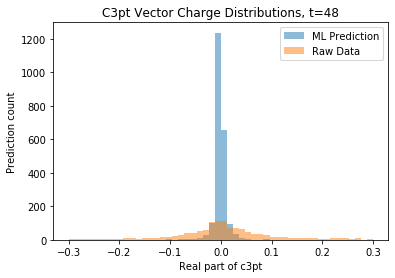

Prediction quality @ t=49: 2774.266433829482


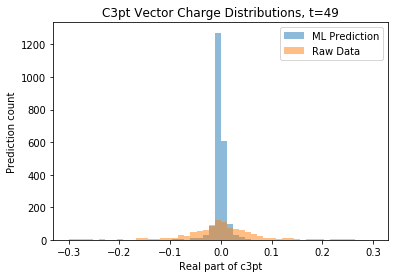

Prediction quality @ t=50: 23.993462732027236


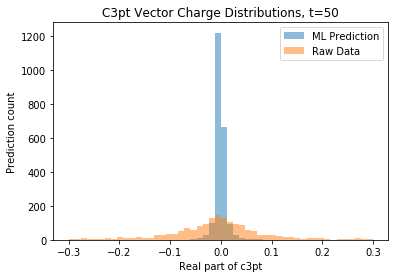

Prediction quality @ t=51: 23.370935789804424


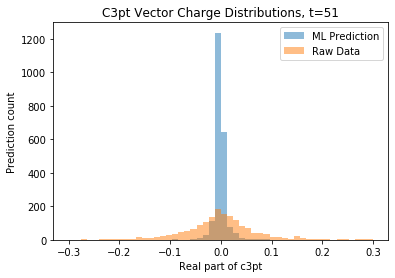

Prediction quality @ t=52: 23.107446829560157


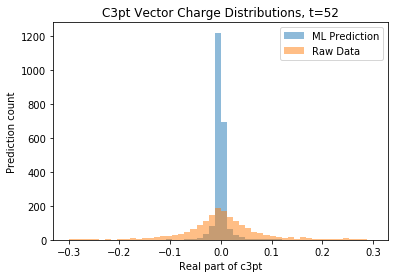

Prediction quality @ t=53: 23.027727204363003


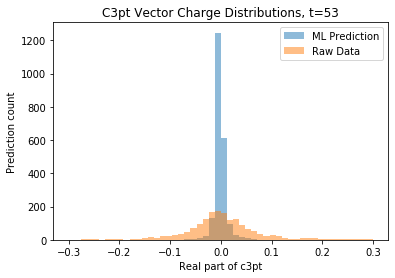

Prediction quality @ t=54: 22.489534751163784


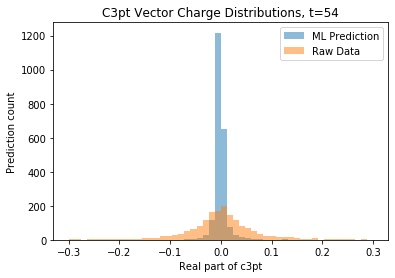

Prediction quality @ t=55: 22.485326336169614


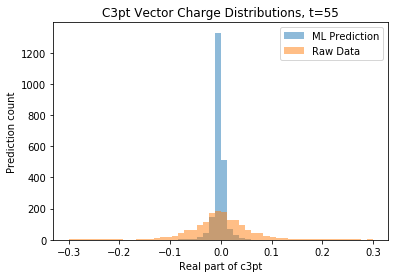

Prediction quality @ t=56: 22.008229505317704


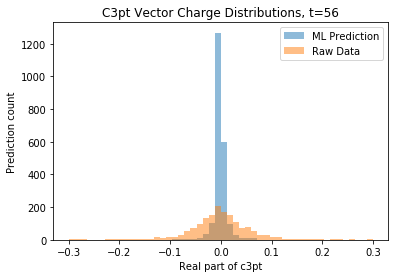

Prediction quality @ t=57: 2424.6252873311496


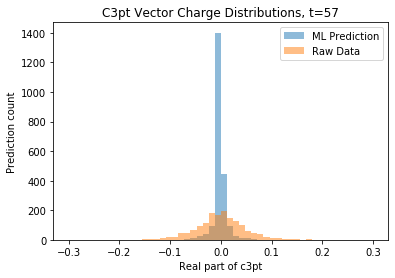

Prediction quality @ t=58: 1.5045059226979722


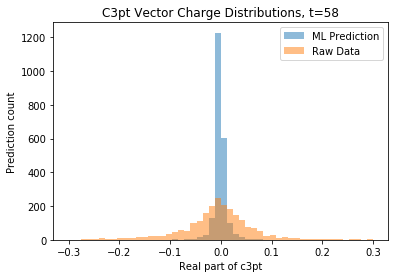

Prediction quality @ t=59: 1.1260581670869867


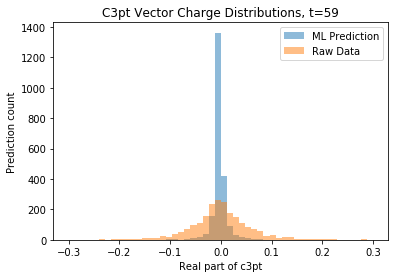

Prediction quality @ t=60: 0.9220008972893894


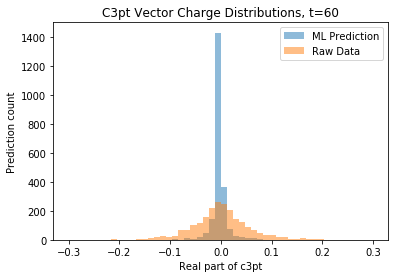

Prediction quality @ t=61: 0.9505092131205969


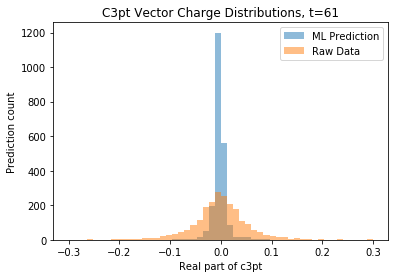

Prediction quality @ t=62: 0.8438712626968975


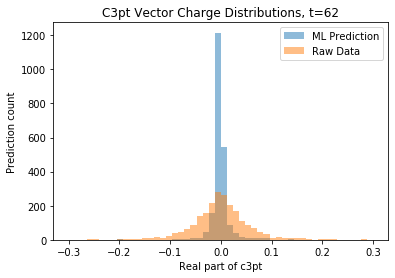

Prediction quality @ t=63: 0.6053185829188252


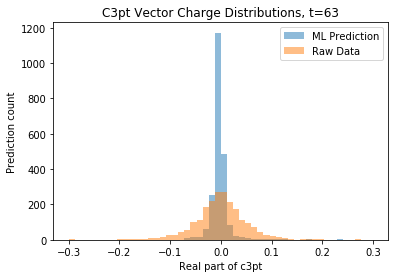

-0.0031464493094098085


NameError: name 'Y_train' is not defined

In [52]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))

    plt.hist(ML_samples, bins=50, range=[-0.3, 0.3], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-0.3, 0.3], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])
        
    avgDiff = (sum(DM_samples) - sum(ML_samples)) / len(DM_samples)
    print(avgDiff)

    quals.append(np.std(errors) / np.std(Y_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

0.2683412313007251


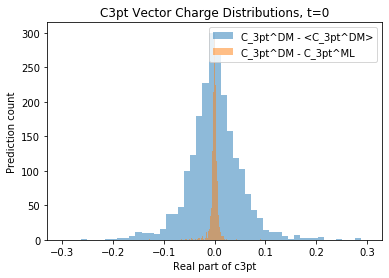

0.2523528522529506


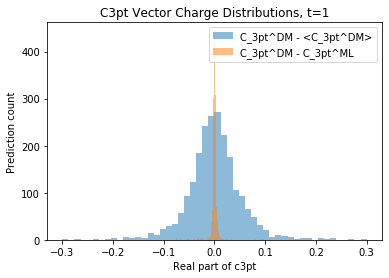

0.2944282373516758


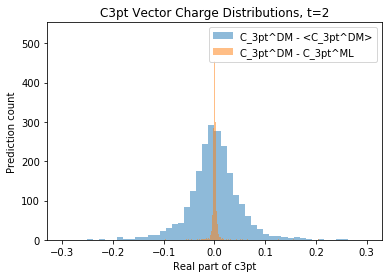

0.2169448484458093


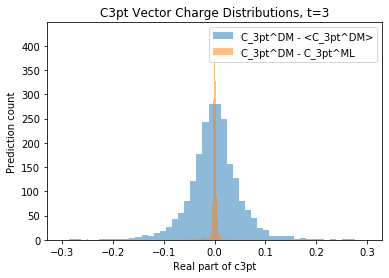

0.24159370468980962


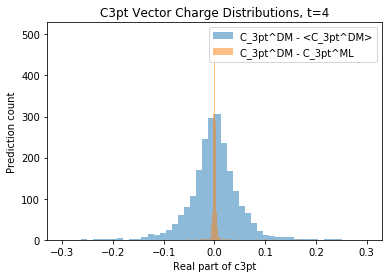

0.26638933737046055


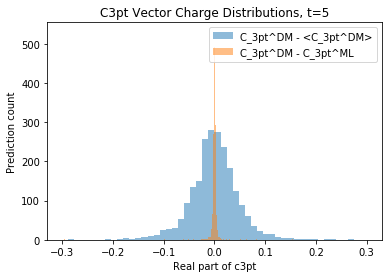

0.24715368498063808


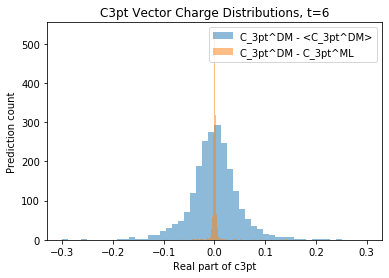

0.2705337986236557


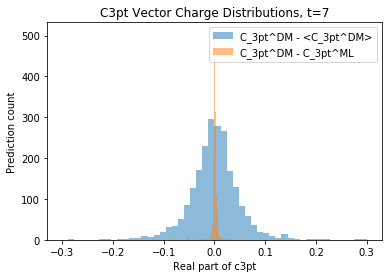

0.3982731568472487


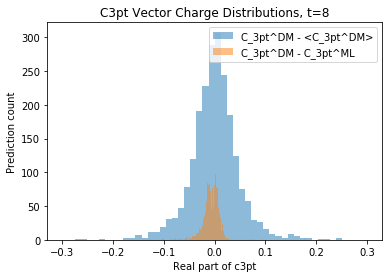

0.46417299201570983


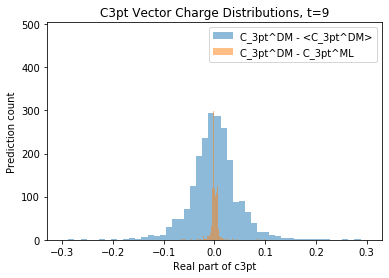

0.6642282113731874


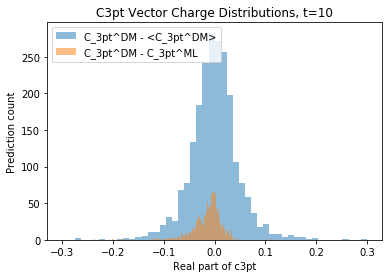

0.6666835904149823


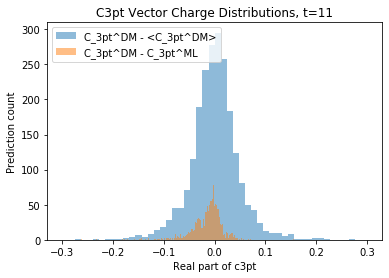

0.6575101829464536


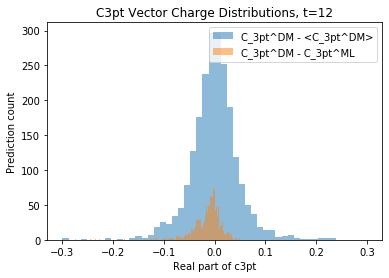

0.6595207627544124


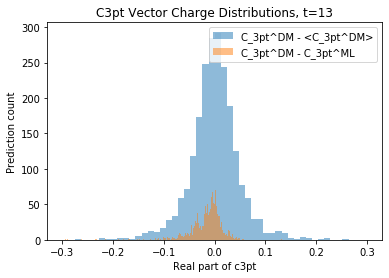

0.6610864630623742


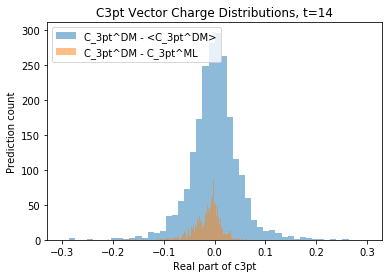

0.6379852708196542


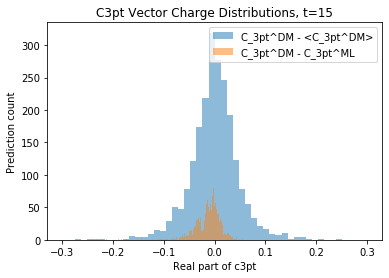

0.8765337867598305


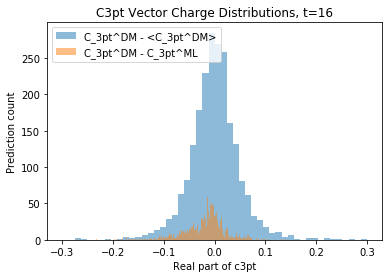

0.5833093531755065


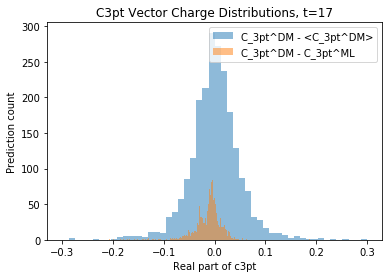

0.6259382467925307


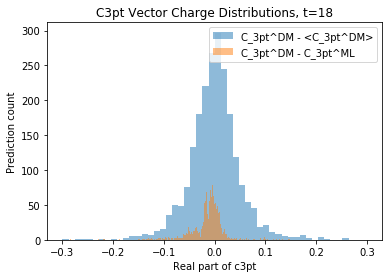

0.6553304929059319


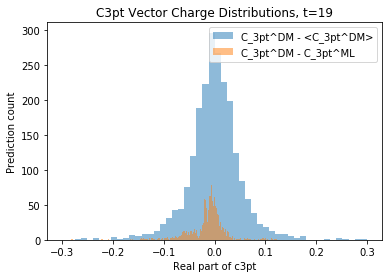

0.6431474154196731


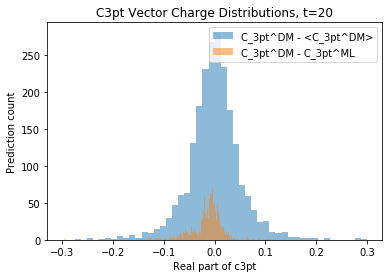

0.6486717119469717


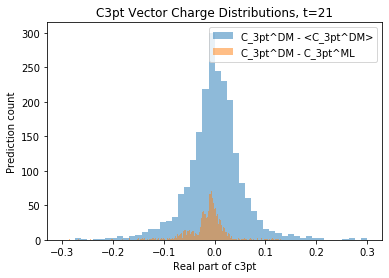

0.6505366630493797


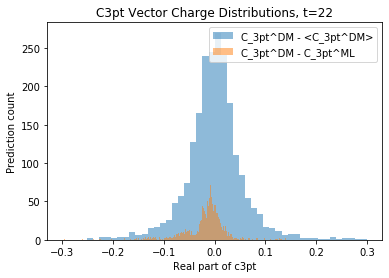

0.6426585478419571


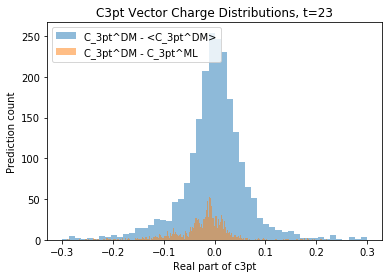

0.771235007038127


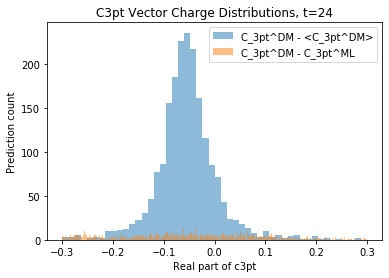

0.6005938596696184


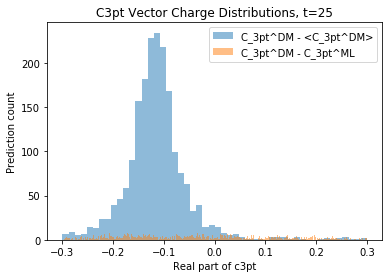

1.2135197802745414


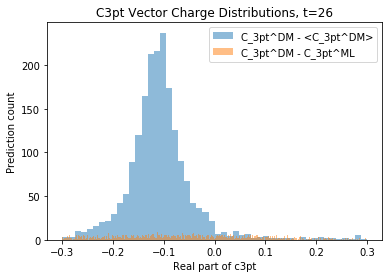

1.2161371727549766


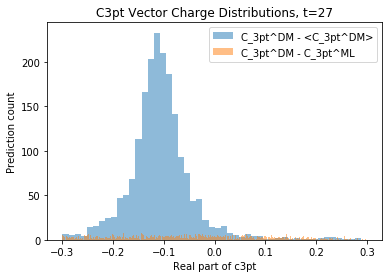

1.2264505893952526


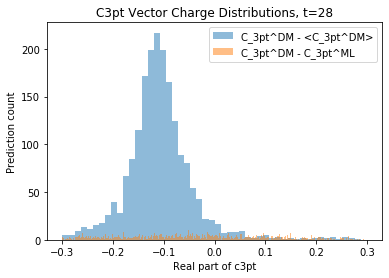

1.2654278916747155


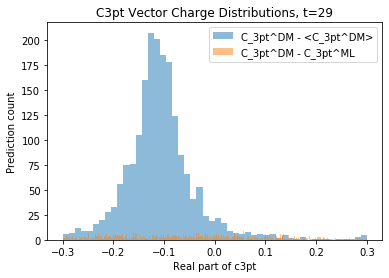

1.2487976583775475


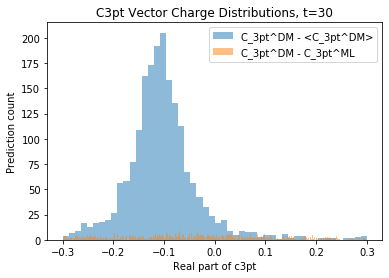

1.2704785106502734


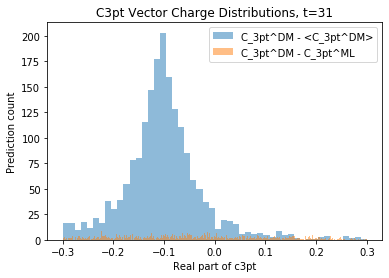

1.2695048189847764


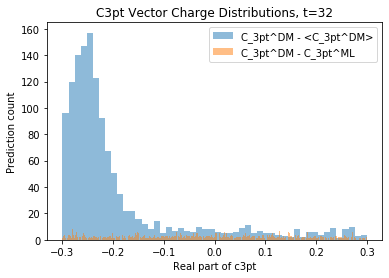

1.2165006664901246


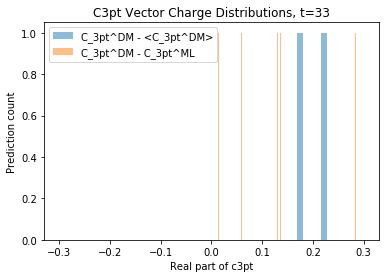

17.429725675269925


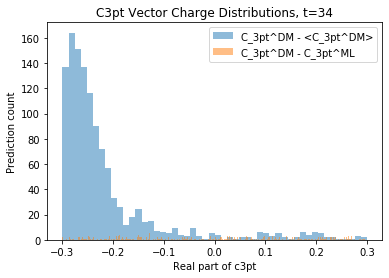

21.3906608868643


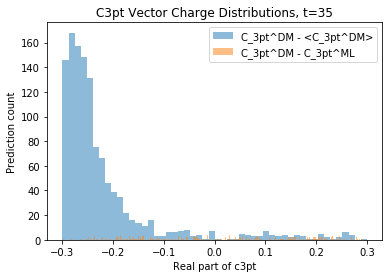

21.299681104826387


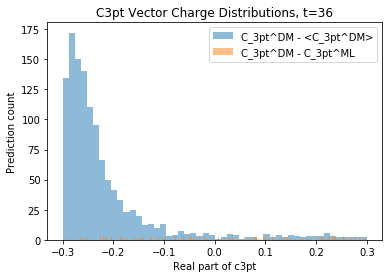

22.42009728921604


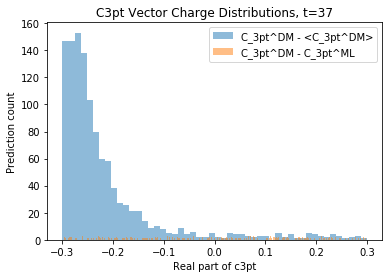

23.135423765216313


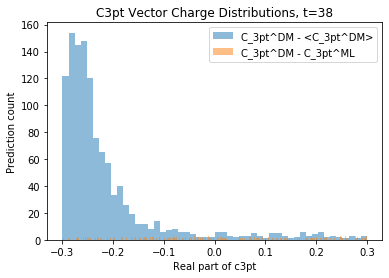

23.450112138856763


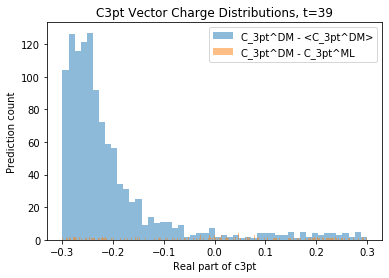

27.274245648332112


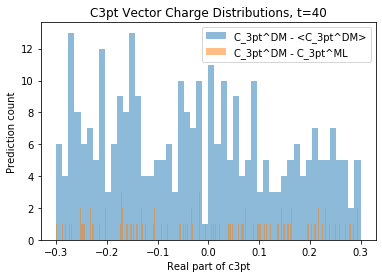

2690.0633383012237


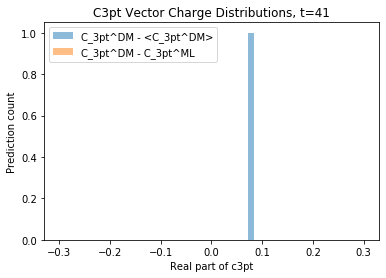

23.800953755426367


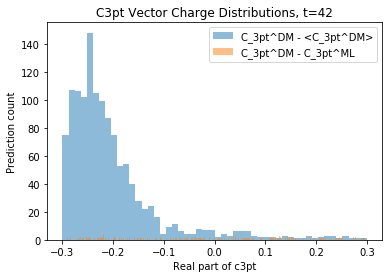

23.853601508196192


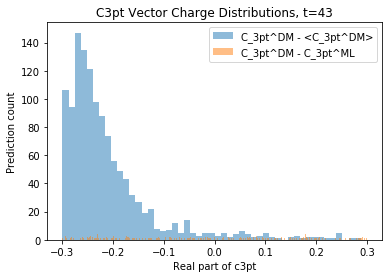

23.25110447961615


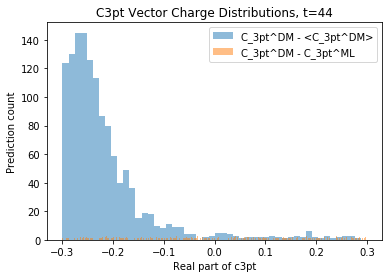

24.36732881680437


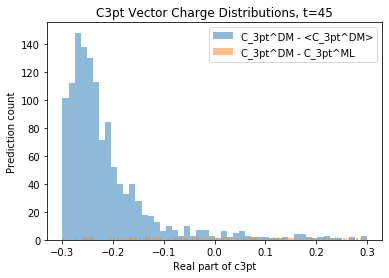

24.312212615676433


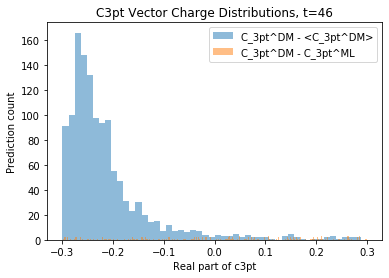

24.223851098275198


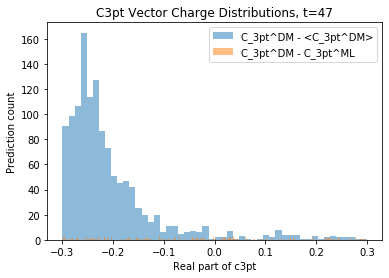

27.61913643666007


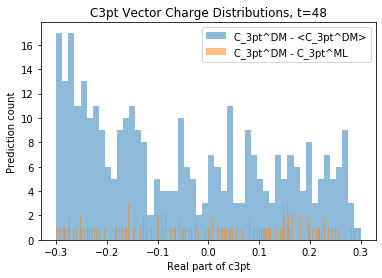

2774.266433829482


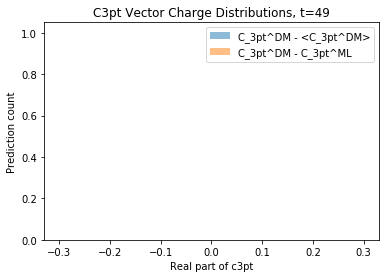

23.993462732027233


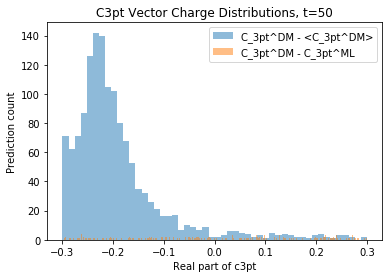

23.37093578980442


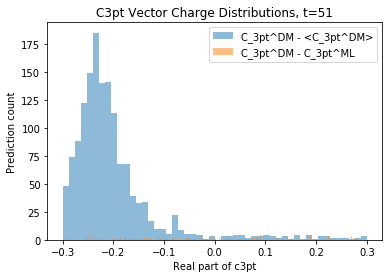

23.107446829560157


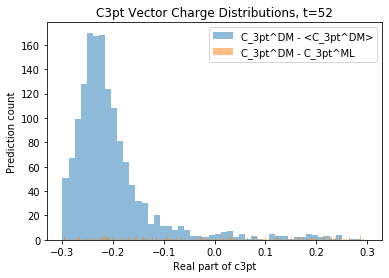

23.027727204363003


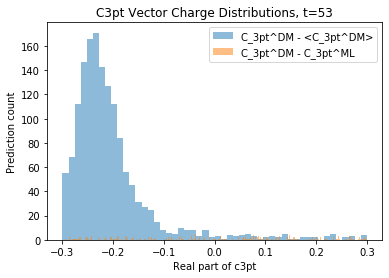

22.489534751163788


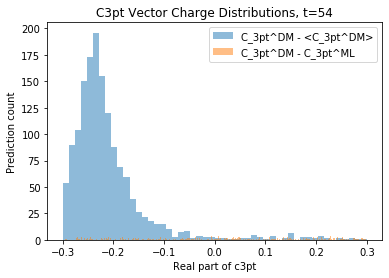

22.485326336169614


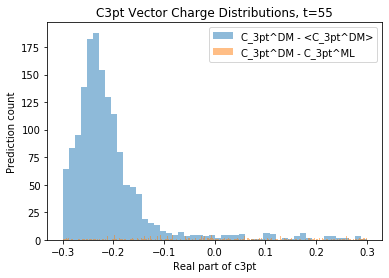

22.008229505317704


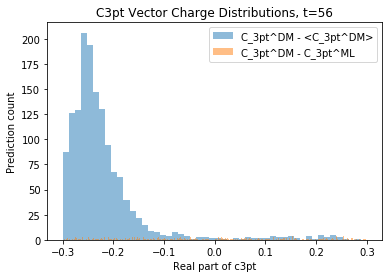

2424.6252873311496


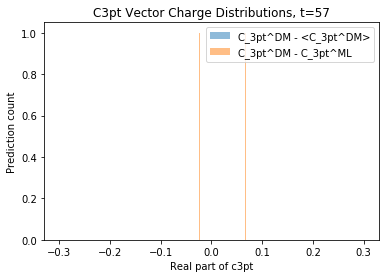

1.5045059226979725


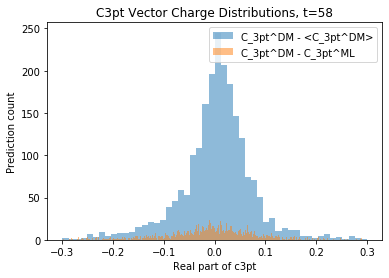

1.1260581670869867


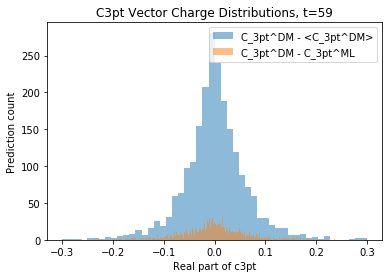

0.9220008972893894


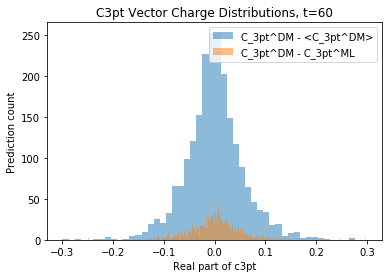

0.950509213120597


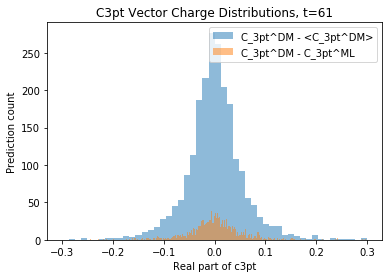

0.8438712626968976


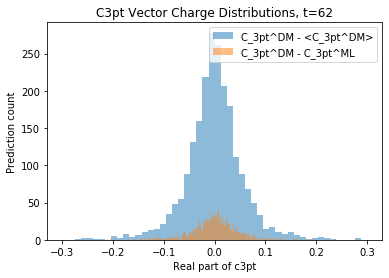

0.6053185829188252


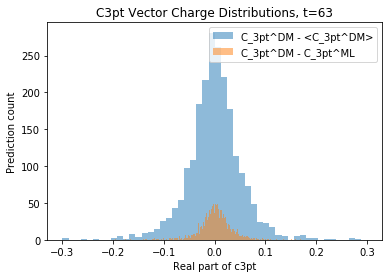

In [65]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append((testLabel_up - pred_up[0]) / np.std(Y_train_up[t]) * np.std(Y_test_up[t]))
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))

    plt.hist(DM_samples, bins=50, range=[-0.3, 0.3], alpha=0.5)
    plt.hist(errors, bins=500, range=[-0.3, 0.3], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

## Axial Charge Prediction With ML Bias Correction

In [66]:
labelFrac = 0.5

labelEnd = int(len(labels_V_up[0]) * labelFrac)

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_A_up[:, :labelEnd], labels_A_down[:, :labelEnd]
X_test, Y_test_up, Y_test_down = features[:, labelEnd:], labels_A_up[:, labelEnd:], labels_A_down[:, labelEnd:]

samps = 64

gbr_up = list(range(samps))
gbr_down = list(range(samps))
gbr_up_congl = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr_down_congl = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)

for i in range(samps):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

# Y_train_up_avg = np.sum(Y_train_up, axis=0) / len(Y_train_up)
# Y_train_down_avg = np.sum(Y_train_down, axis=0) / len(Y_train_down)

# gbr_up_congl.fit(X_train[0], Y_train_up_avg)
# gbr_down_congl.fit(X_train[0], Y_train_down_avg)

Prediction quality @ t=0: 0.4815093213586332


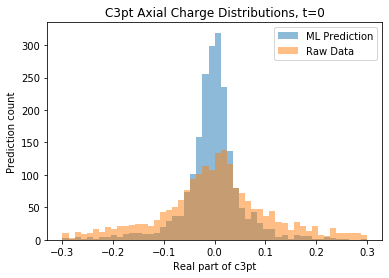

Prediction quality @ t=1: 0.4099702314038515


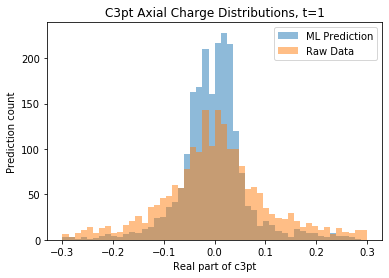

Prediction quality @ t=2: 0.3399648796305736


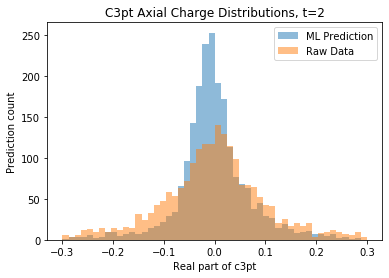

Prediction quality @ t=3: 0.33396565500616315


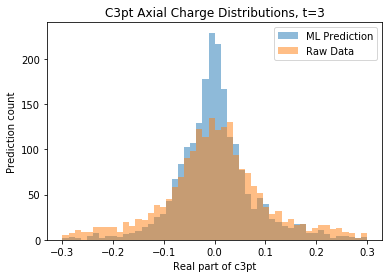

Prediction quality @ t=4: 0.2947960943383123


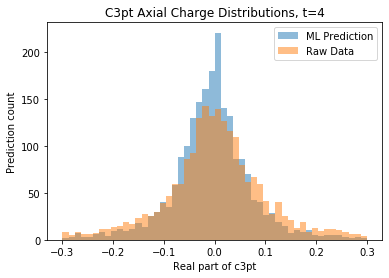

Prediction quality @ t=5: 0.2999794852819563


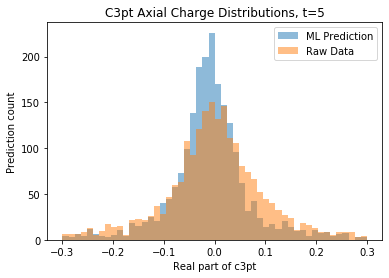

Prediction quality @ t=6: 0.28917116571596424


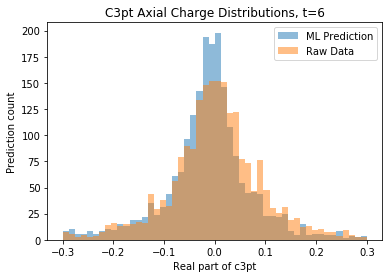

Prediction quality @ t=7: 0.275410821505735


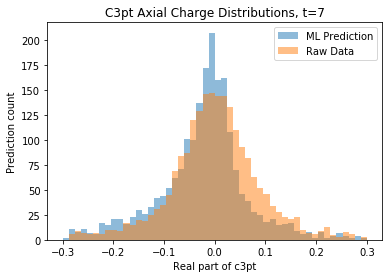

Prediction quality @ t=8: 0.2782565151782271


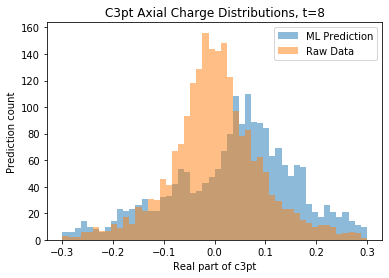

Prediction quality @ t=9: 0.2687164788335465


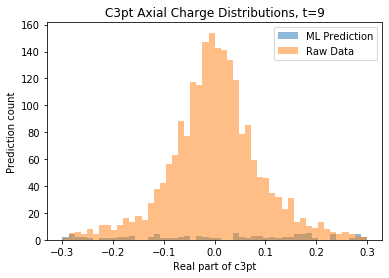

Prediction quality @ t=10: 0.32032970561820884


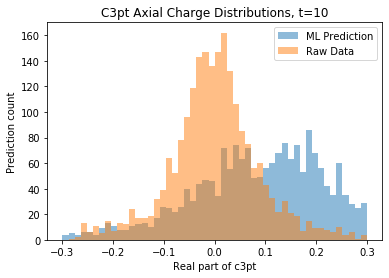

Prediction quality @ t=11: 0.3647543058100583


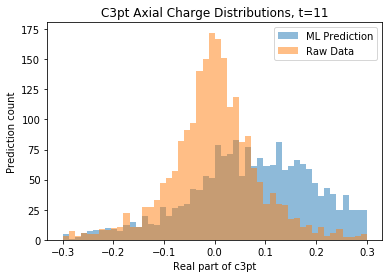

Prediction quality @ t=12: 0.3418527620260546


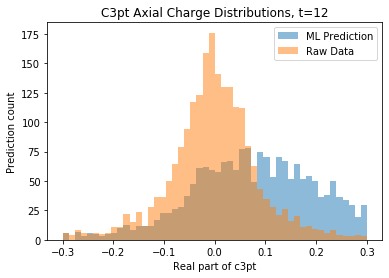

Prediction quality @ t=13: 0.34079397053355703


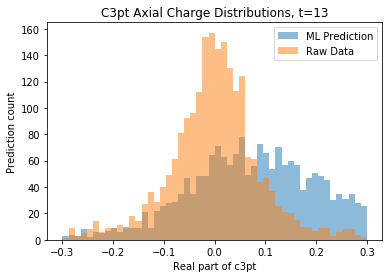

Prediction quality @ t=14: 0.38147620165733936


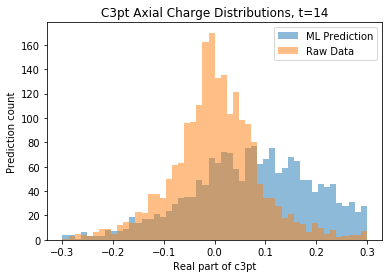

Prediction quality @ t=15: 0.33657823397175124


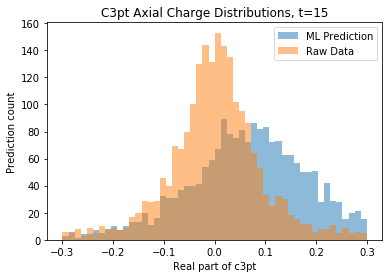

Prediction quality @ t=16: 0.5127622737331908


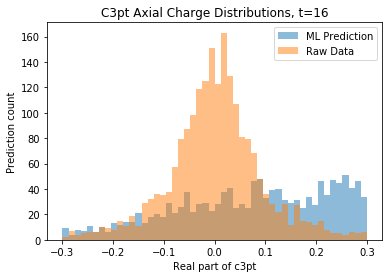

Prediction quality @ t=17: 0.41400728822216293


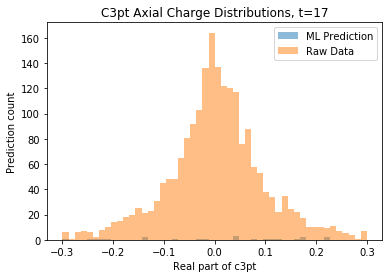

Prediction quality @ t=18: 0.4214184258464105


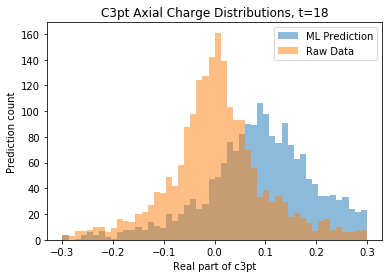

Prediction quality @ t=19: 0.4368235084797793


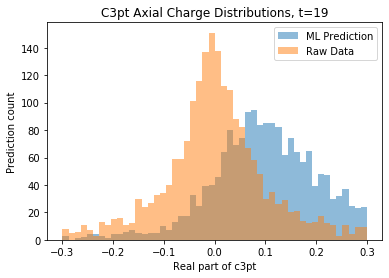

Prediction quality @ t=20: 0.4858698889688475


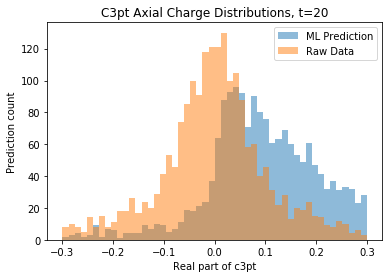

Prediction quality @ t=21: 0.4984274374293809


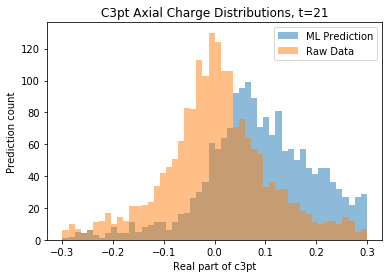

Prediction quality @ t=22: 0.5503940166824194


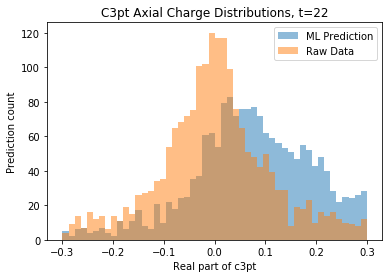

Prediction quality @ t=23: 0.5853348370725558


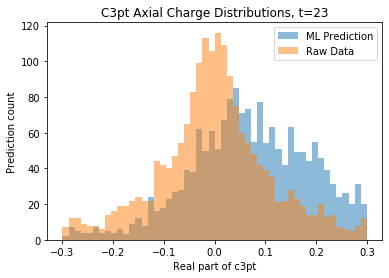

Prediction quality @ t=24: 0.6515318139127533


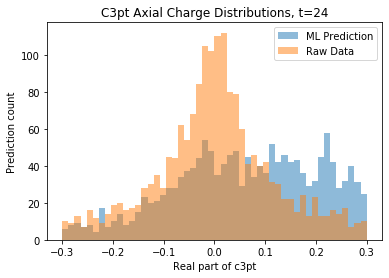

Prediction quality @ t=25: 0.3835000652422647


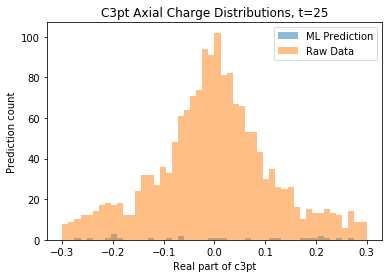

Prediction quality @ t=26: 0.896118641091954


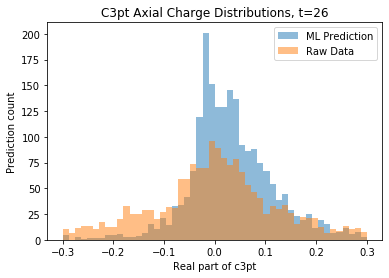

Prediction quality @ t=27: 0.9712840736764596


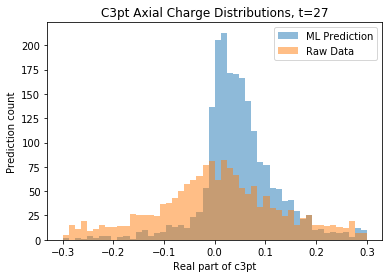

Prediction quality @ t=28: 1.1224509715513173


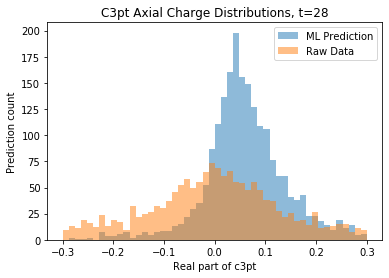

Prediction quality @ t=29: 1.2106498509489705


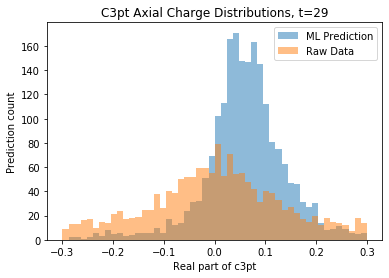

Prediction quality @ t=30: 1.2728369590384172


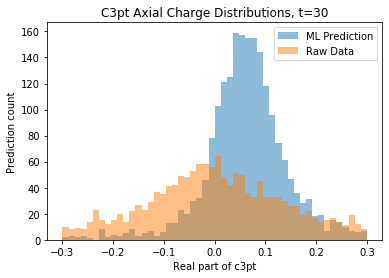

Prediction quality @ t=31: 1.4040159283137958


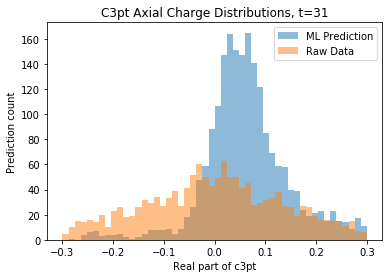

Prediction quality @ t=32: 1.4630537517316504


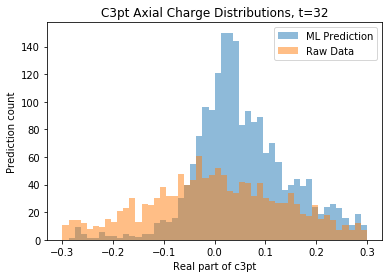

Prediction quality @ t=33: 1.3319407061237714


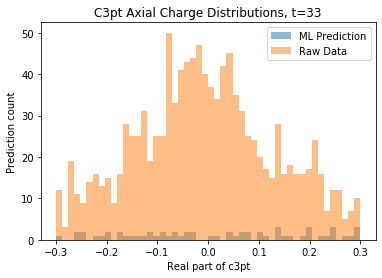

Prediction quality @ t=34: 2.473472380621693


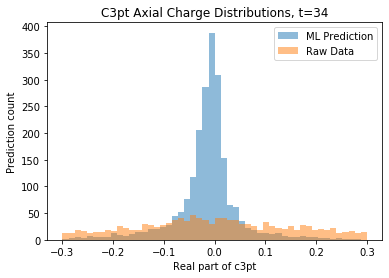

Prediction quality @ t=35: 2.664163440344634


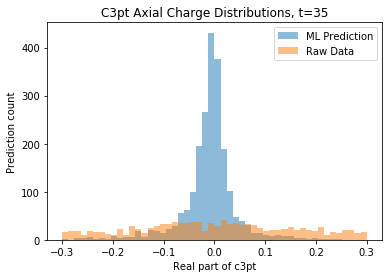

Prediction quality @ t=36: 3.0026591858747347


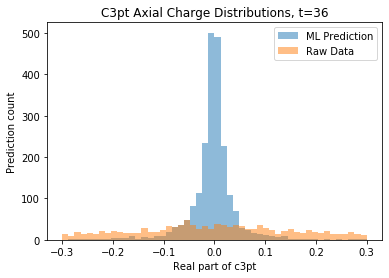

Prediction quality @ t=37: 3.2879523742306653


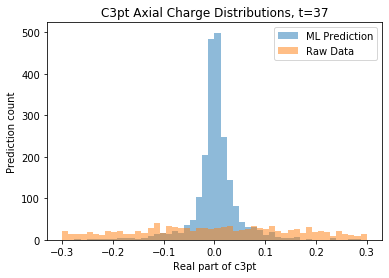

Prediction quality @ t=38: 3.610679705171987


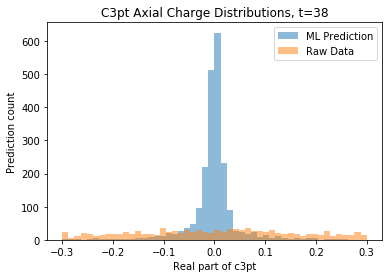

Prediction quality @ t=39: 4.197077207647663


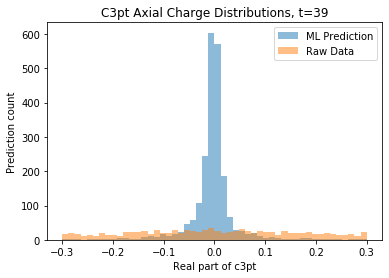

Prediction quality @ t=40: 5.204244546751062


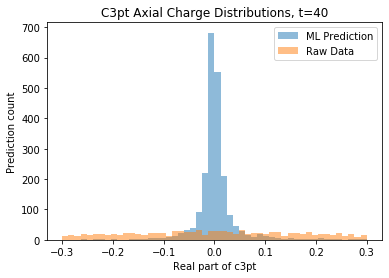

Prediction quality @ t=41: 786.882627414583


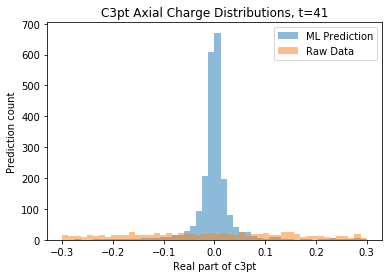

Prediction quality @ t=42: 5.832228968295239


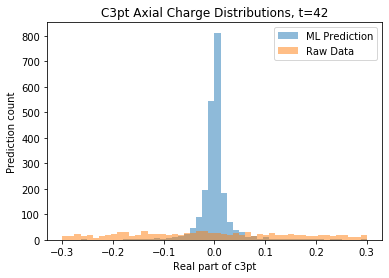

Prediction quality @ t=43: 6.114223931157883


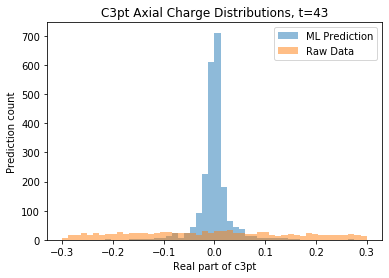

Prediction quality @ t=44: 6.142534073274618


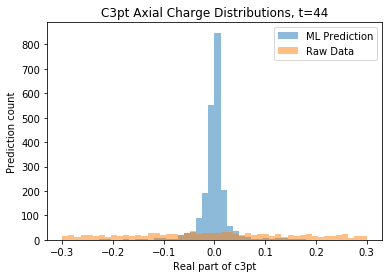

Prediction quality @ t=45: 6.855114025984636


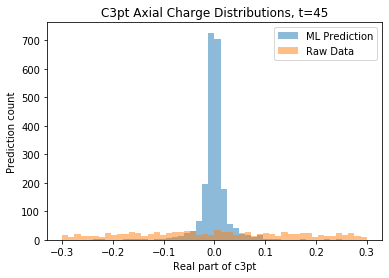

Prediction quality @ t=46: 7.515522013786525


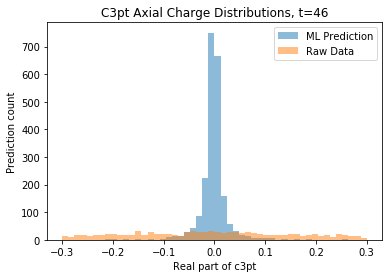

Prediction quality @ t=47: 8.253565940118222


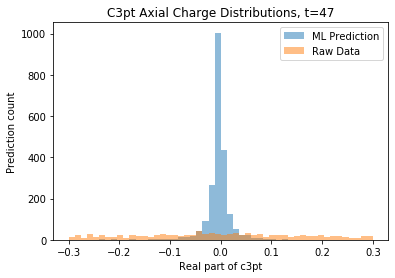

Prediction quality @ t=48: 8.469014570682283


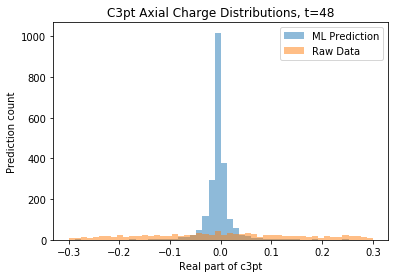

Prediction quality @ t=49: 1049.7954602033851


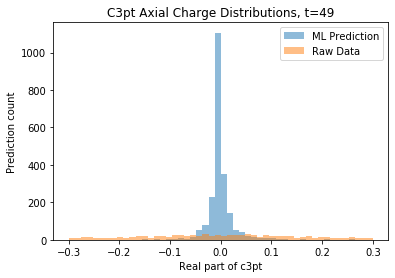

Prediction quality @ t=50: 6.9884920413779925


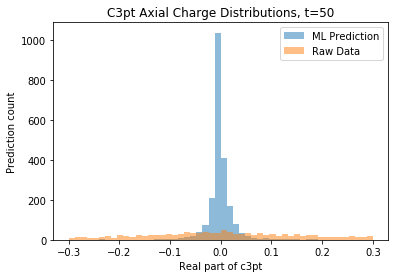

Prediction quality @ t=51: 6.465880415743348


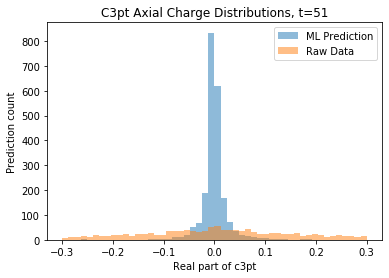

Prediction quality @ t=52: 5.778480350492467


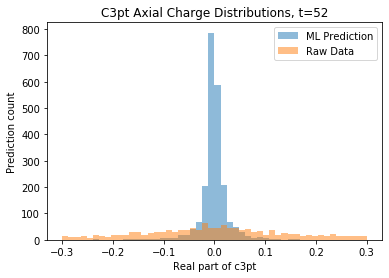

Prediction quality @ t=53: 5.1460648911583995


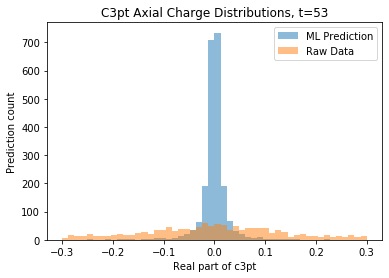

Prediction quality @ t=54: 4.602666579695019


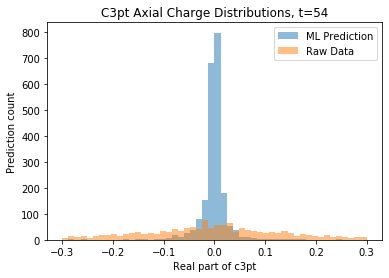

Prediction quality @ t=55: 4.0149770328714816


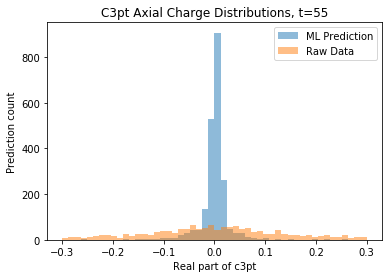

Prediction quality @ t=56: 3.5126448805318122


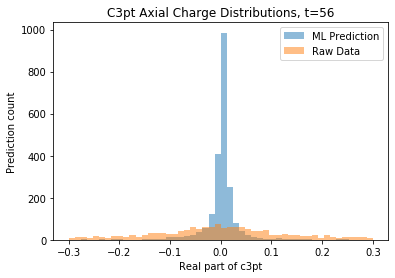

Prediction quality @ t=57: 474.9253241994453


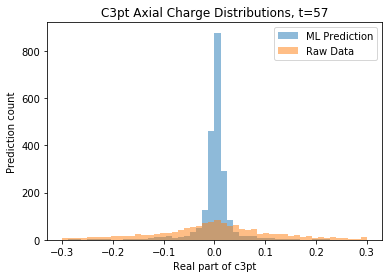

Prediction quality @ t=58: 1.6307264222489721


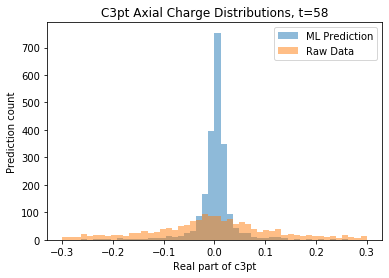

Prediction quality @ t=59: 1.2499571145601478


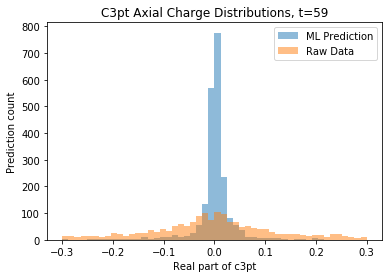

Prediction quality @ t=60: 1.0443397498870033


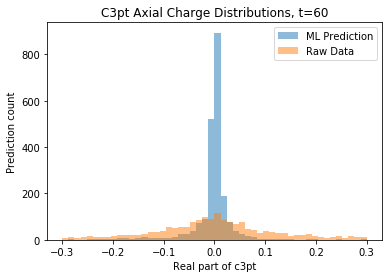

Prediction quality @ t=61: 0.9130488116004796


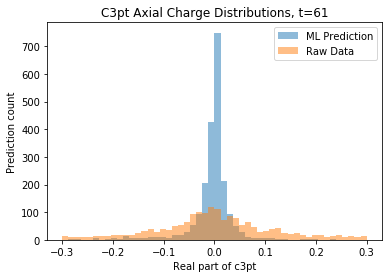

Prediction quality @ t=62: 0.7391827529579413


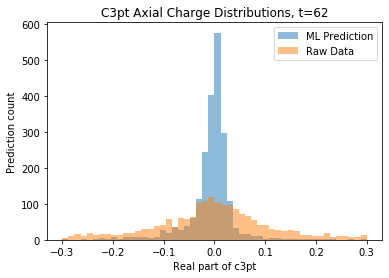

Prediction quality @ t=63: 0.5587347001199774


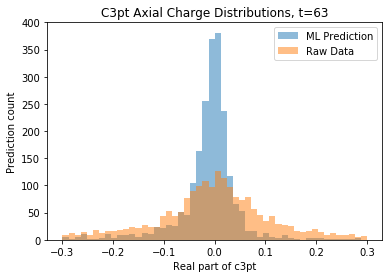

-0.005841475726038554


NameError: name 'Y_train' is not defined

In [67]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(Y_train_up[t]))

    plt.hist(ML_samples, bins=50, range=[-0.3, 0.3], alpha=0.5)
    plt.hist(DM_samples, bins=50, range=[-0.3, 0.3], alpha=0.5)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Axial Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append(pred_up[0] - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])
        
    avgDiff = (sum(DM_samples) - sum(ML_samples)) / len(DM_samples)
    print(avgDiff)

    quals.append(np.std(errors) / np.std(Y_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

0.4815093213586333


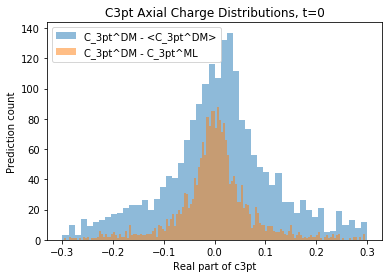

0.4099702314038515


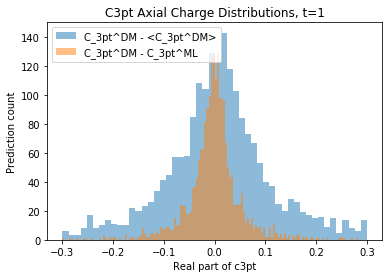

0.3399648796305736


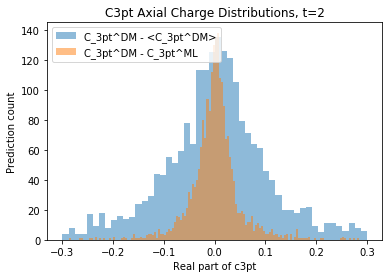

0.33396565500616315


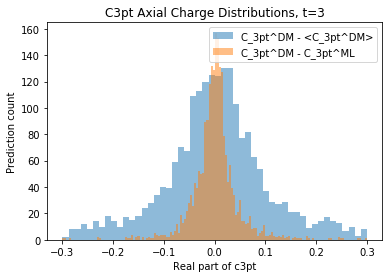

0.2947960943383122


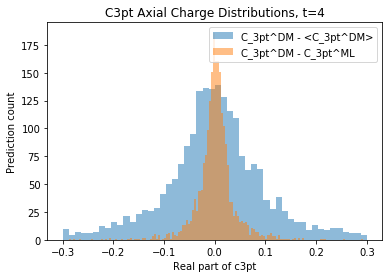

0.2999794852819563


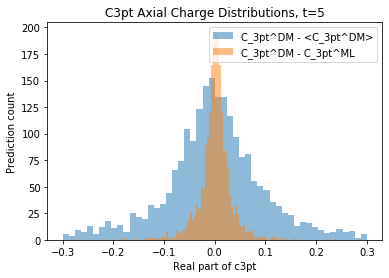

0.2891711657159643


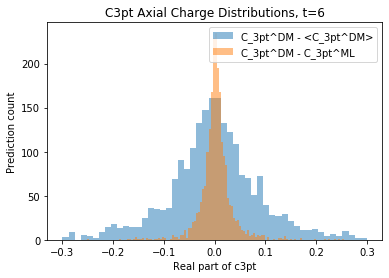

0.275410821505735


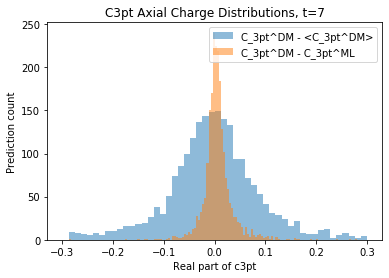

0.27825651517822714


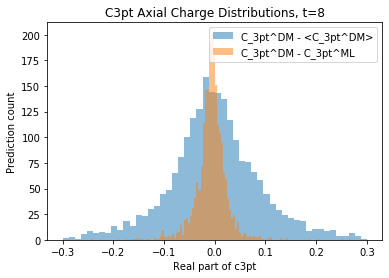

0.26871647883354643


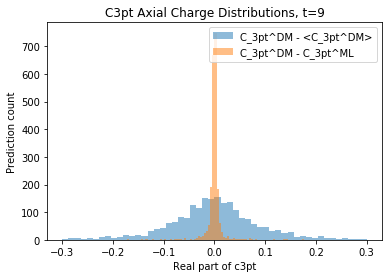

0.32032970561820884


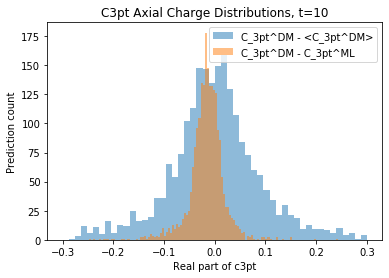

0.3647543058100583


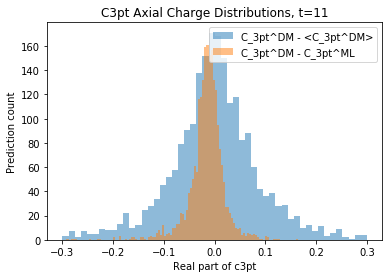

0.3418527620260546


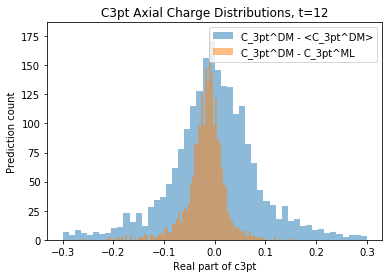

0.34079397053355703


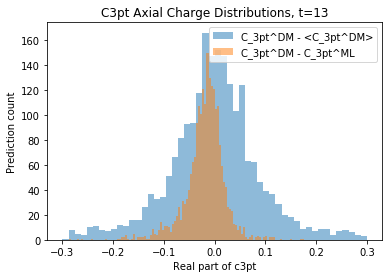

0.38147620165733936


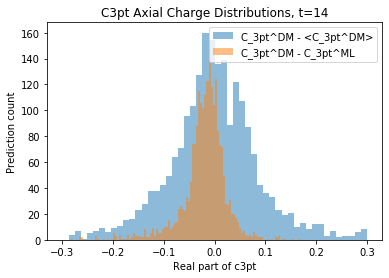

0.33657823397175124


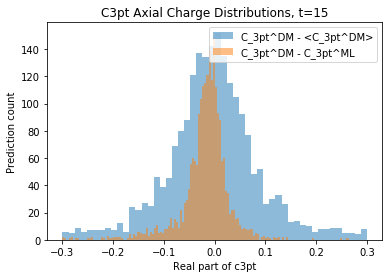

0.5127622737331908


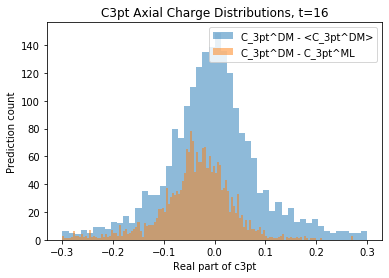

0.414007288222163


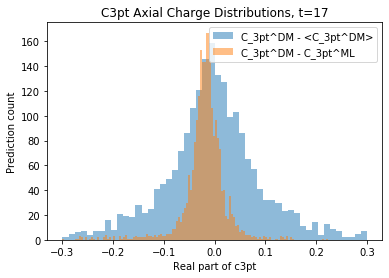

0.42141842584641054


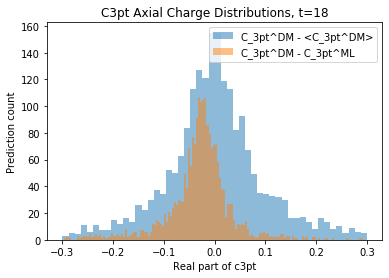

0.4368235084797793


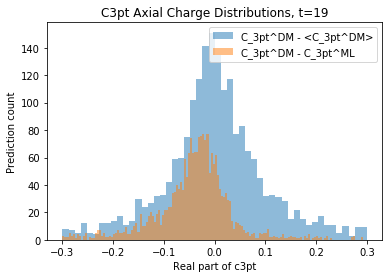

0.4858698889688475


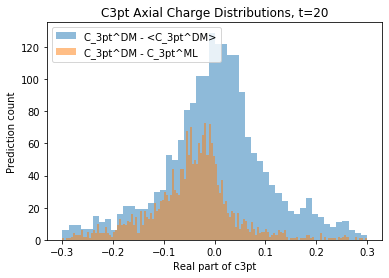

0.49842743742938084


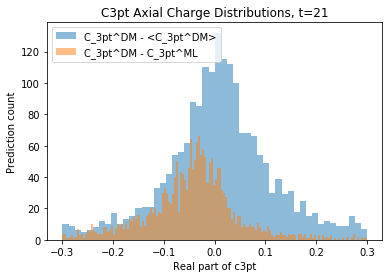

0.5503940166824195


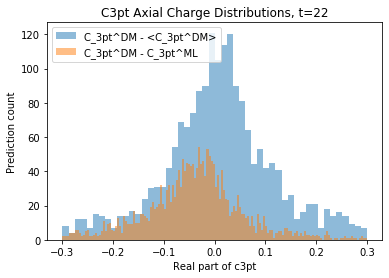

0.5853348370725557


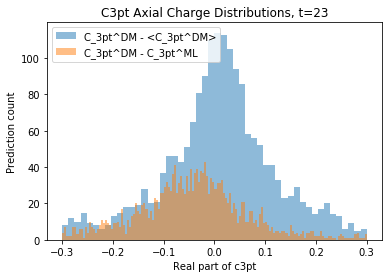

0.6515318139127534


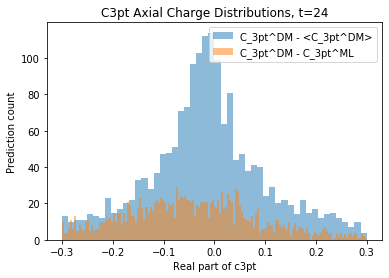

0.38350006524226476


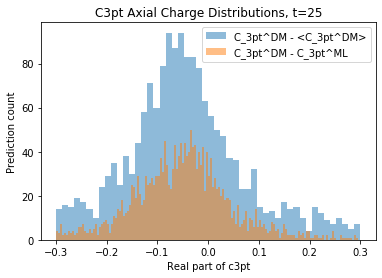

0.896118641091954


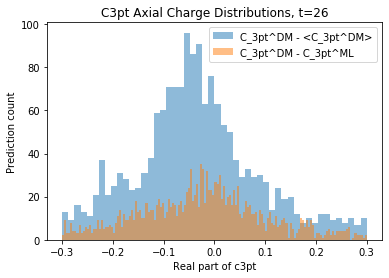

0.9712840736764596


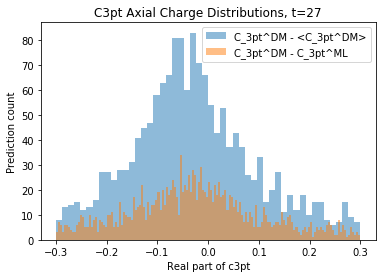

1.1224509715513173


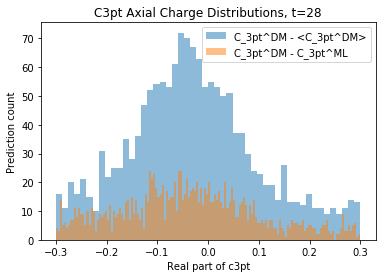

1.2106498509489707


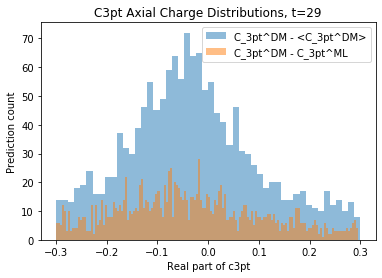

1.272836959038417


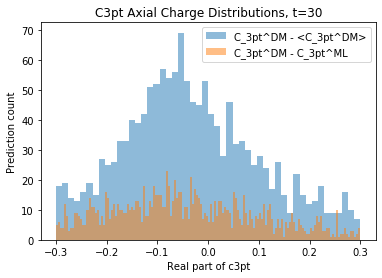

1.4040159283137956


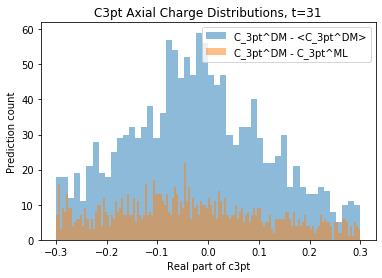

1.4630537517316504


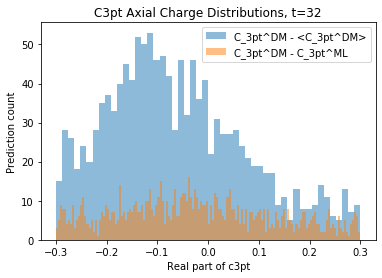

1.3319407061237714


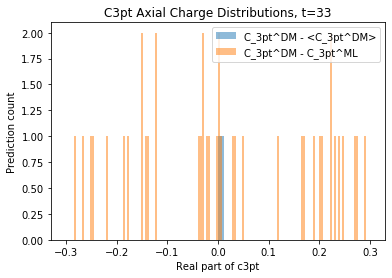

2.473472380621693


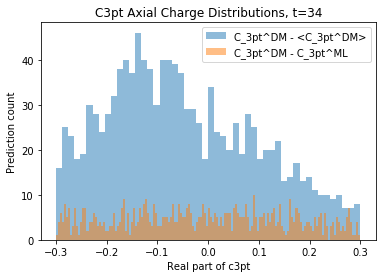

2.6641634403446335


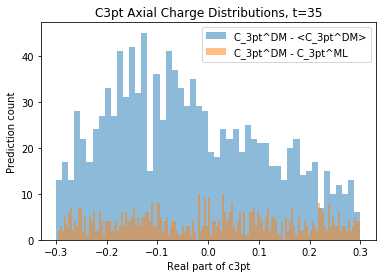

3.0026591858747347


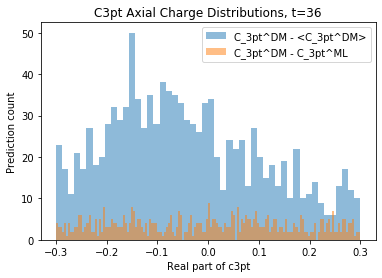

3.2879523742306653


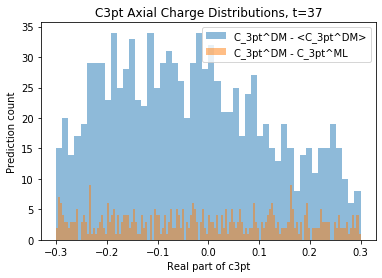

3.6106797051719877


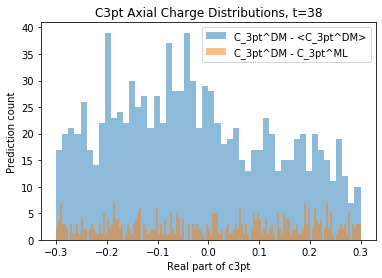

4.197077207647663


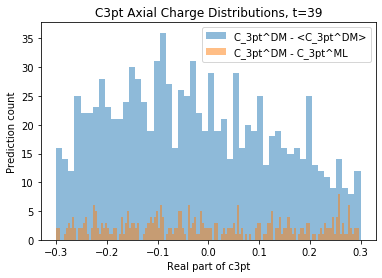

5.204244546751062


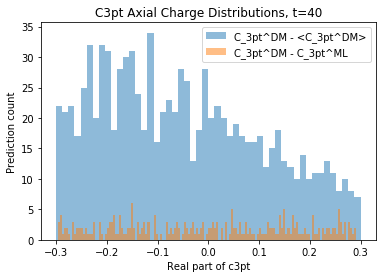

786.882627414583


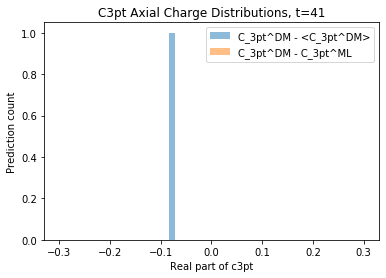

5.83222896829524


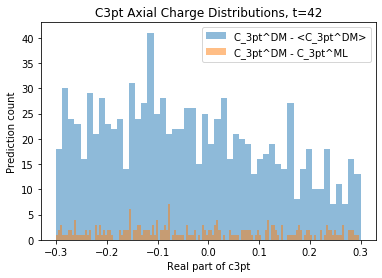

6.114223931157884


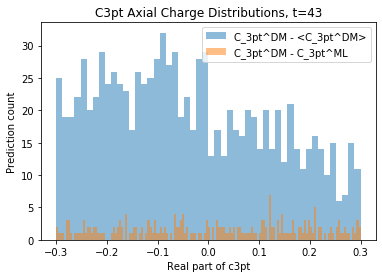

6.142534073274619


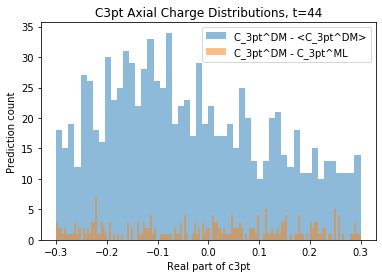

6.855114025984637


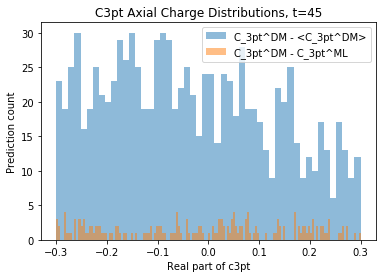

7.515522013786524


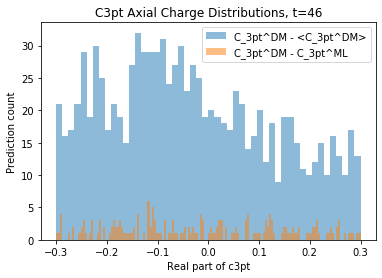

8.253565940118222


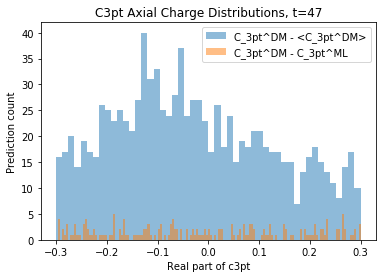

8.469014570682283


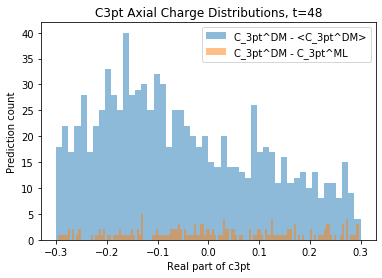

1049.7954602033851


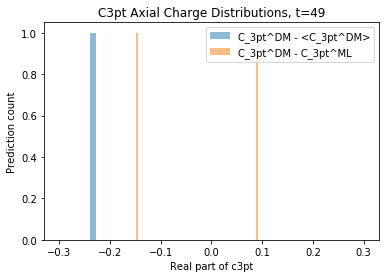

6.9884920413779925


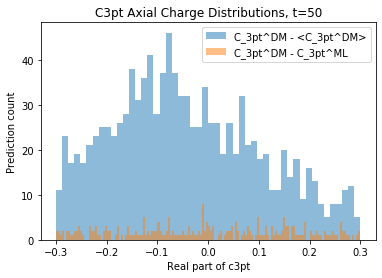

6.465880415743347


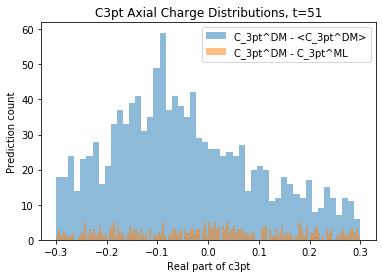

5.778480350492467


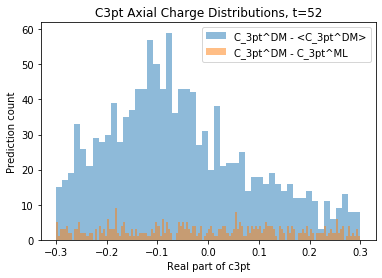

5.1460648911583995


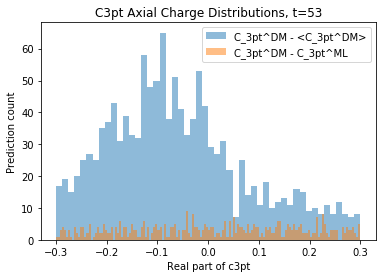

4.60266657969502


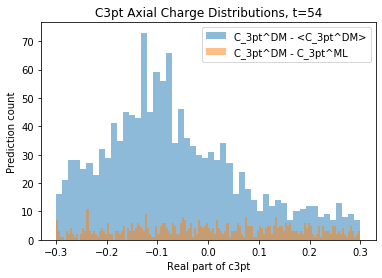

4.0149770328714816


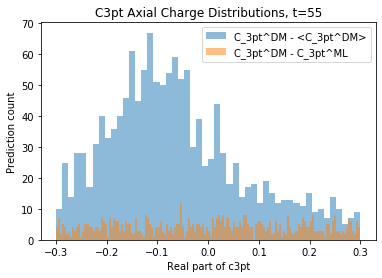

3.5126448805318127


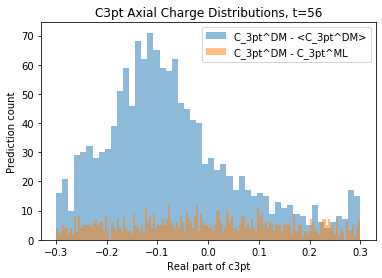

474.92532419944524


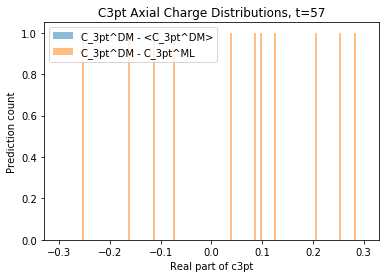

1.630726422248972


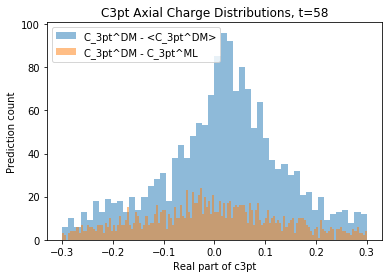

1.2499571145601478


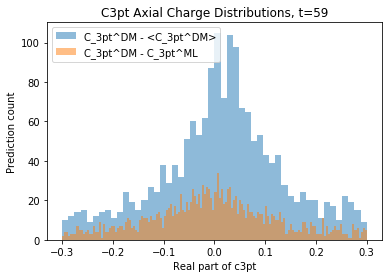

1.0443397498870033


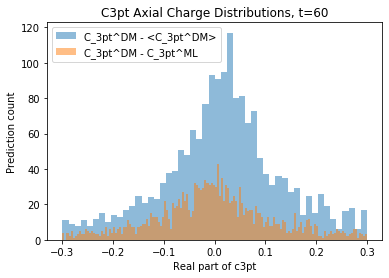

0.9130488116004797


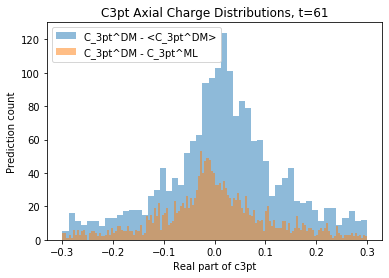

0.7391827529579414


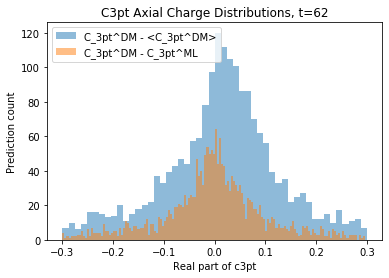

0.5587347001199774


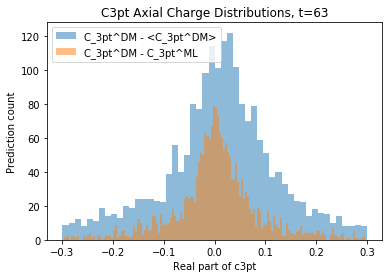

In [71]:
for t in range(samps):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test[t])):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg])
        errors.append((testLabel_up - pred_up[0]) / np.std(Y_train_up[t]) * np.std(Y_test_up[t]))
        DM_samples.append(testLabel_up)
        
    DM_avg = np.average(np.array(DM_samples))
    for i in range(len(DM_samples)):
        DM_samples[i] -= DM_avg
        
    print(np.std(errors) / np.std(Y_test_up[t]))

    plt.hist(DM_samples, bins=50, range=[-0.3, 0.3], alpha=0.5)
    plt.hist(errors, bins=150, range=[-0.3, 0.3], alpha=0.5)
    plt.legend(["C_3pt^DM - <C_3pt^DM>", "C_3pt^DM - C_3pt^ML"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Axial Charge Distributions, t=" + str(t))
    plt.show()